# DC inversions in settings with steel cased wells

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from string import ascii_lowercase
import ipywidgets
import time

import discretize
from SimPEG import (
    Utils, Maps, Inversion, Regularization, DataMisfit, InvProblem,
    Optimization, Directives
)
from SimPEG import Problem, Survey, Props
from SimPEG import DC
from SimPEG.EM import TDEM
from pymatsolver import Pardiso

import casingSimulations as casingSim

%matplotlib inline

In [2]:
rcParams['font.size'] = 14

In [3]:
sim_dir = 'DC_halfspace'

## Model

- approximate the casing as a solid cylinder, conductivity equals to the conductivity thickness product
- use effective medium theory to estimate the conductivity of the target

In [4]:
# casing parameters
casing_l = 1000
sigma_back = 1e-2
casing_d = 10e-2
casing_t = 1e-2
sigma_casing = 5e6

sigma_casing_homogenized = sigma_casing * np.pi*((casing_d/2)**2 - (casing_d/2 - casing_t)**2)
print('The conductivity of the cylinder is {:1.2e} S/m'.format(sigma_casing_homogenized))

The conductivity of the cylinder is 1.41e+04 S/m


In [5]:
# proppant-fluid parameters
sigma_proppant = 1e4
sigma_fluid = 3
phi_proppant = 0.5

In [6]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant)
sigma_pf = (scemt * np.r_[phi_proppant])[0]
print('The conductivity of the proppant-fluid mixture is {:1.2f} S/m'.format(sigma_pf))

The conductivity of the proppant-fluid mixture is 2506.73 S/m


In [7]:
# fracture geometry
n_fracs = 10
fracture_thickness = 3e-3
fracture_width = 10. # 10m wide fracture zone
fracture_radius = 50.
fracture_top = -950.

In [8]:
V_total = np.pi * fracture_radius**2 * fracture_width 
V_frac = np.pi * fracture_radius**2 * fracture_thickness*n_fracs
phi_frac = V_frac/V_total

print("The concentration of fractures by volume is {}".format(phi_frac))

The concentration of fractures by volume is 0.003


In [9]:
alpha = (fracture_thickness*0.5)/50

print("We assume an aspect ratio of {}".format(alpha))

We assume an aspect ratio of 3e-05


In [10]:
scemt_fractures = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha
)

In [11]:
sigma_frac = (scemt_fractures * np.r_[phi_frac])[0]
print('The conductivity of the fractured region of rock is {:1.2f} S/m'.format(sigma_frac))

The conductivity of the fractured region of rock is 3.31 S/m


In [12]:
model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=sim_dir,
    sigma_casing= sigma_casing_homogenized,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_casing_homogenized,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    sigma_target = sigma_frac,  # conductivity of the fractured region
    casing_d = casing_d-casing_d/2,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_d/2, 
    target_radius = np.r_[0., fracture_radius],
    target_z = fracture_top + np.r_[-fracture_width, 0.],
    src_a = np.r_[0., np.pi, -975.],  # put the A electrode just below the surface
    src_b = np.r_[2000., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

In [13]:
model.casing_b

0.05

In [14]:
model.serialize()

{'filename': 'ModelParameters.json',
 'directory': 'DC_halfspace',
 'version': '0.0.6',
 'sigma_casing': 14137.166941154077,
 'sigma_inside': 14137.166941154077,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.05,
 'casing_t': 0.05,
 'target_radius': [0.0, 50.0],
 'target_z': [-960.0, -950.0],
 'target_theta': [0.0, 6.283185307179586],
 'sigma_target': 3.306452089817292,
 'sigma_back': 0.01,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'src_a': [0.0, 3.141592653589793, -975.0],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 '__class__': 'CasingInHalfspaceWithTarget'}

In [15]:
copied_model_params = copiedmodelparams = {
    key: val for key, val in model.serialize().items() 
    if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}
background = casingSim.model.CasingInHalfspace(**copied_model_params)

In [16]:
model_names = ["background", "fracture"]
model_dict = {
    "background": background, 
    "fracture": model
}

## Mesh

In [17]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 9, 16  # number of padding cells
pfx2 = 1.5  # expansion factor for the padding to infinity in the x-direction
pfz = 1.5

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(1)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=sim_dir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_b/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)
mesh = cylMeshGen.mesh

In [18]:
print("The mesh has {} cells".format(mesh.nC))

The mesh has 42432 cells


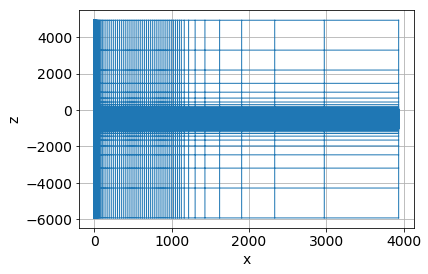

In [19]:
cylMeshGen.mesh.plotGrid()

## Physical Properties

In [20]:
phys_props_dict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, val) for key, val in model_dict.items()
}

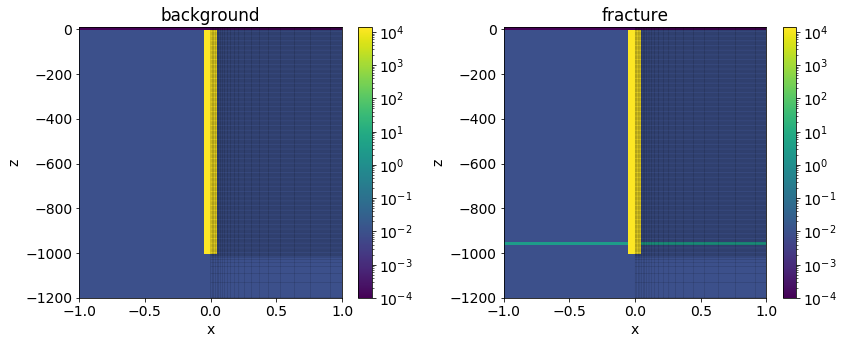

In [28]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 1*np.r_[-1, 1]
ylim = [-1200, 10]
plot_mesh = True

for a, key in zip(ax, model_names):
    phys_props_dict[key].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, linewidth=0.1, color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

## Survey

In [29]:
rx_x = np.linspace(25, 1000, 40)
rx_z = np.r_[-1.25]  # slightly below the surface for better interpolation 
rx_locs = Utils.ndgrid([rx_x, np.r_[0], rx_z])

rx_list = [DC.Rx.BaseRx(rx_locs, 'ex')]

In [30]:
include_obswell = False

if include_obswell is True:
    rx2_x = np.r_[250.]
    rx2_z = np.linspace(-1000, -25, 40)
    rx2_locs = Utils.ndgrid([rx2_x, np.r_[0.], rx2_z])
    
    rx_list += [DC.Rx.BaseRx(rx2_locs, 'ez')]

In [31]:
experiment = 4

if experiment == 1:
    z_locs = np.r_[-975] + cylMeshGen.csz/2
    src_a = np.atleast_2d(model.src_a)
    src_a[0, 2] = z_locs[0]
    src_b = np.atleast_2d(model.src_b)
    
elif experiment == 2:
    z_locs = -1*np.linspace(25, 975, 20) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 3:
    z_locs = -1*np.linspace(25, 1000, 40) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 4:
    z_locs = -1*np.linspace(900, 1000, 10) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

In [32]:
src_list = [DC.Src.Dipole(rx_list, locA=src_a[i, :], locB=src_b[i, :]) for i in range(len(z_locs))]

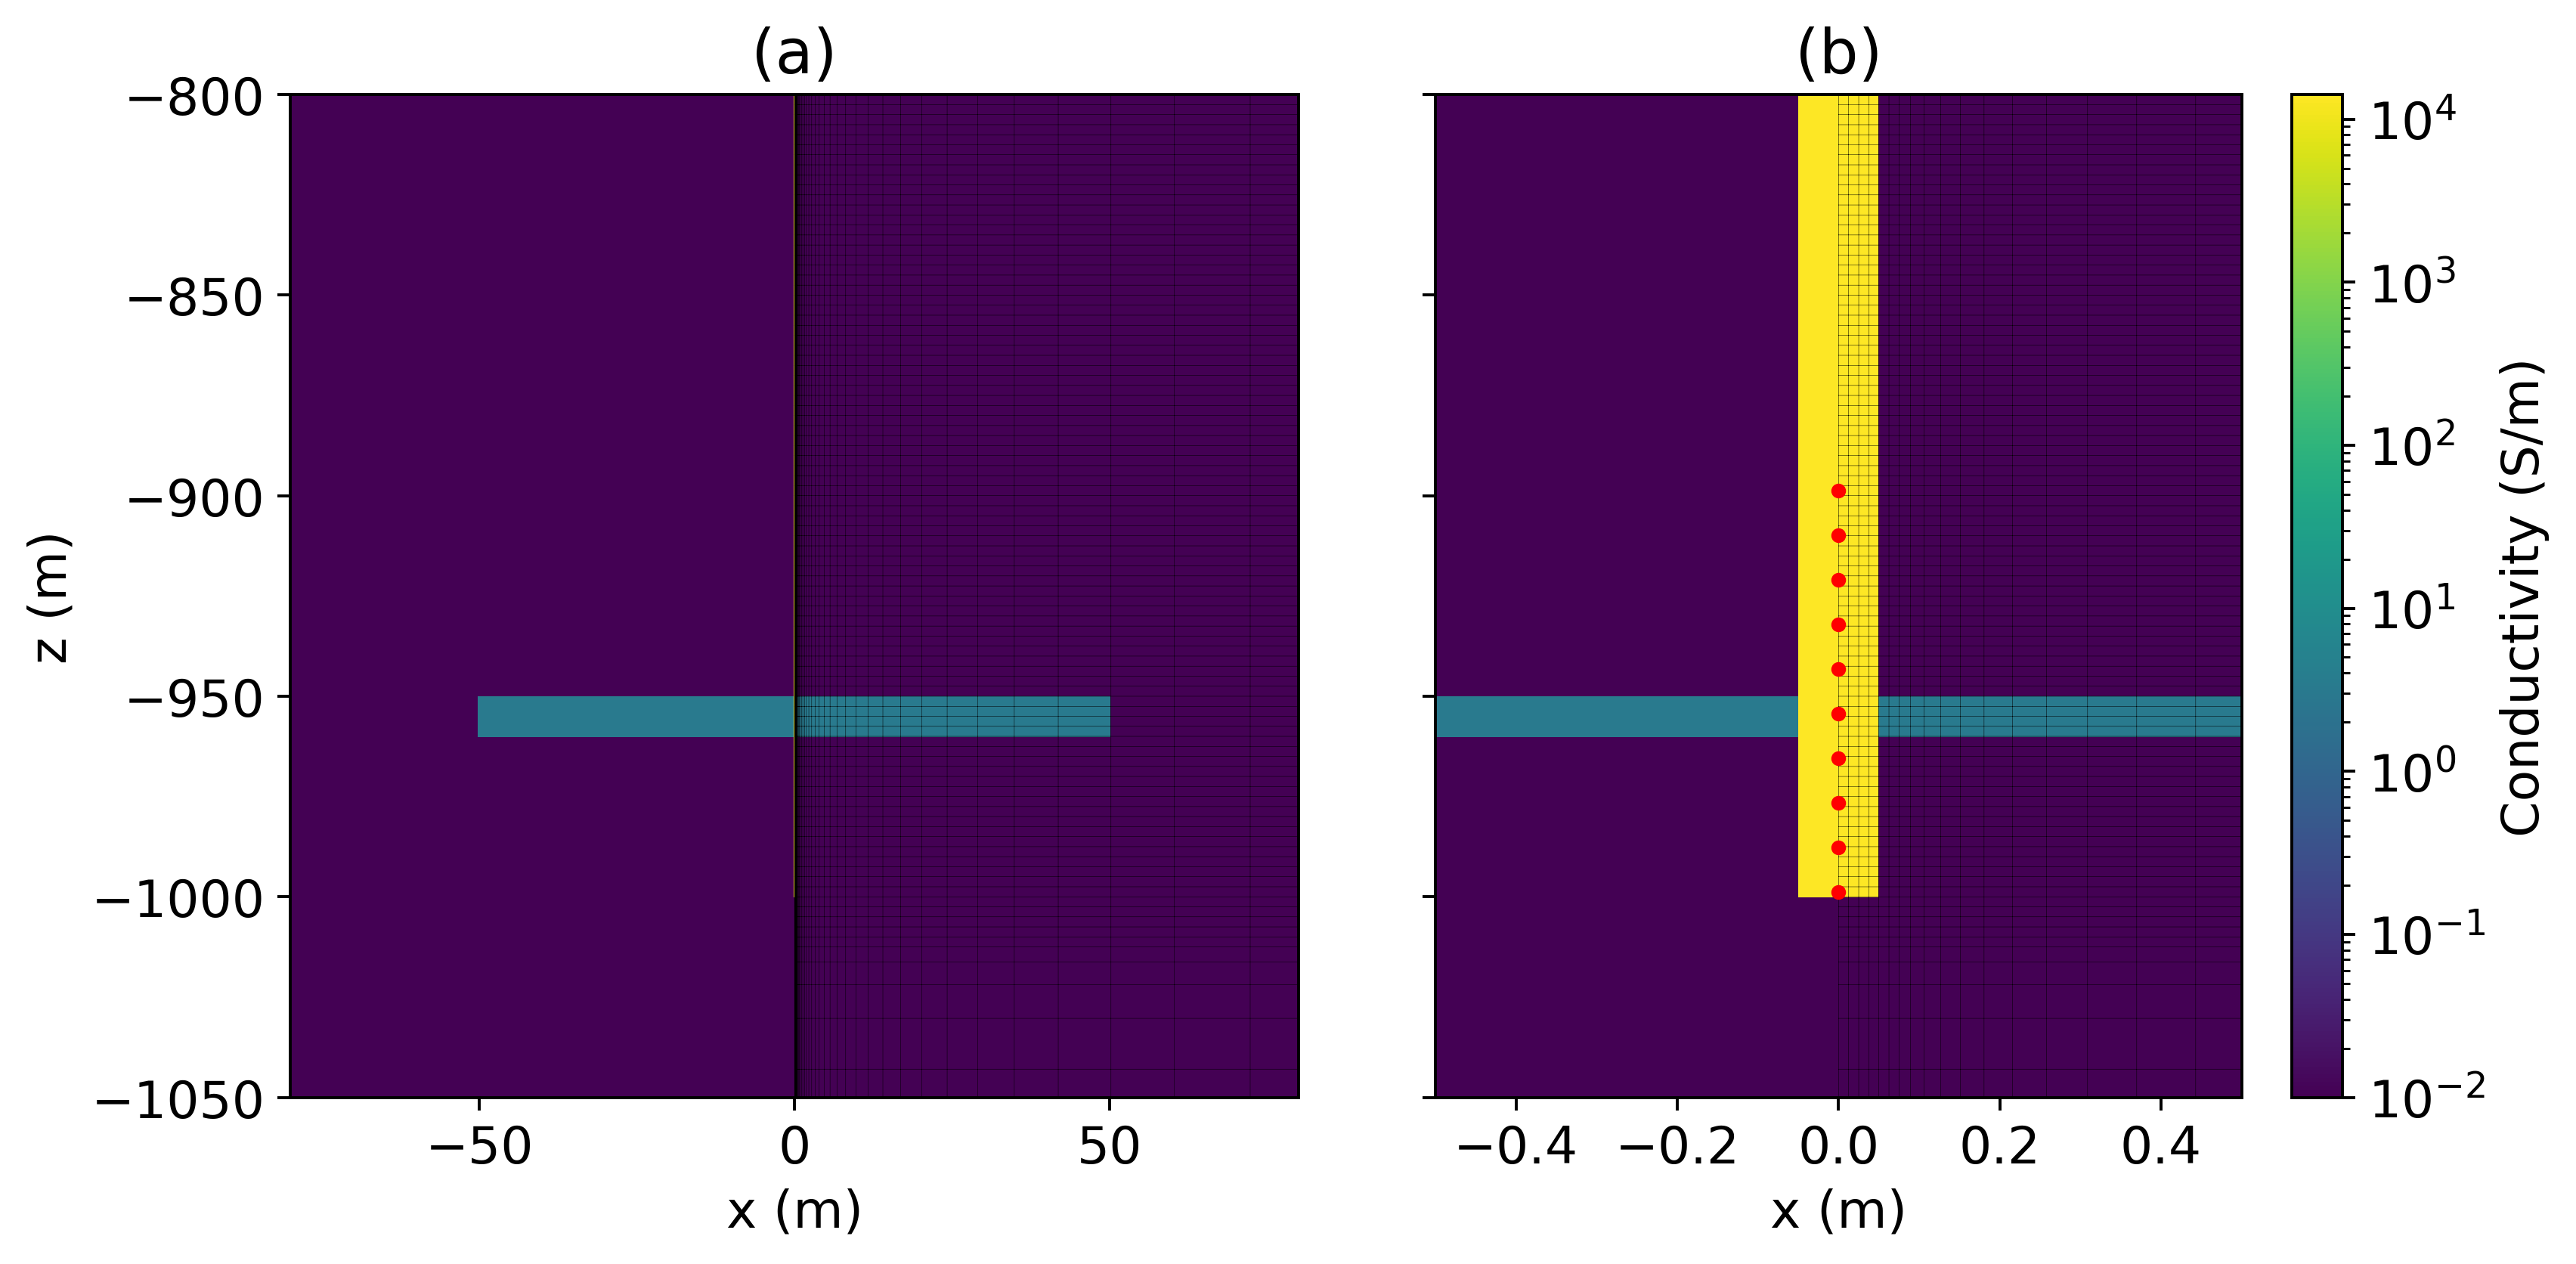

In [35]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5), dpi=350)
xlim_a = 0.5*np.r_[-1, 1]
xlim_b = 80*np.r_[-1, 1]
# ylim_a = [-1200, -800]
ylim = [-1050, -800]

plot_mesh = True
plot_sources = True

for i, a in enumerate(ax):
    out = phys_props_dict[key].plot_sigma(
        ax=a, pcolorOpts={'norm':LogNorm()}, show_cb=True if i==1 else False, clim=np.r_[sigma_back, sigma_casing_homogenized]
    )
    a.set_xlim(xlim_a if i == 1 else xlim_b)
    a.set_ylim(ylim)
    
    if plot_mesh:
        mesh.plotGrid(ax=a, linewidth=0.1, color='k', slice="theta")
        a.grid(None)
    
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_ylabel("z (m)")
    a.set_xlabel("x (m)")
    
    if i == 1:
        out[-1].set_label("Conductivity (S/m)")
        a.set_ylabel('')
        a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if plot_sources:
            a.plot(np.zeros_like(z_locs), z_locs, 'ro', ms=3)

plt.tight_layout()
fig.savefig('../figures/DC_cyl_setup', dpi=350)

## Set up a DC simulation

In [36]:
prob_dict = {}
survey_dict = {}

for key in model_names:
    prob_dict[key] = DC.Problem3D_CC(
        mesh, sigmaMap=Maps.ExpMap(mesh), bc_type='Dirichlet', Solver=Pardiso
    )
    survey_dict[key] = DC.Survey(src_list)
    prob_dict[key].pair(survey_dict[key]) 

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [37]:
survey_dict["fracture"].nD

400

In [38]:
%%time
fields_dict = {}
for key in model_names:
    t = time.time()
    print('Running {}'.format(key))
    fields_dict[key] = prob_dict[key].fields(np.log(phys_props_dict[key].sigma))
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Running background
  ... elapsed time 4.19e-01 s

Running fracture
  ... elapsed time 3.16e-01 s

CPU times: user 925 ms, sys: 87.5 ms, total: 1.01 s
Wall time: 736 ms


In [39]:
%%time
data_dict = {}
for key in model_names:
    t = time.time()
    print('Computing data for {}'.format(key))
    data_dict[key] = survey_dict[key].dpred(
        np.log(phys_props_dict[key].sigma), f=fields_dict[key]
    )
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Computing data for background
  ... elapsed time 7.12e-02 s

Computing data for fracture
  ... elapsed time 6.64e-02 s

CPU times: user 131 ms, sys: 6.35 ms, total: 138 ms
Wall time: 138 ms


In [40]:
def wrangle_data(data, component="x"):
    d = data.reshape(src_list[0].nD, len(src_list), order="F")
    if component == "x": 
        dx = d[:src_list[0].rxList[0].nD, :] 
        return dx
    
    if include_obswell and component == "z":
        dz = d[src_list[0].rxList[0].nD:, :]
        return dz
        
    data_dict[key] = entry

In [41]:
for key, value in data_dict.items():
    entry = {
        "data": value,
        "data_x": wrangle_data(value, "x")
    }
    if include_obswell:
        entry["data_z"] = wrangle_data(value, "z")
    data_dict[key] = entry

## Plot data

In [42]:
phi_frac

0.003

In [43]:
def plot_models(
    m, mapping, xlim=80*np.r_[-1, 1], ylim=[-1050, -800], 
    clim=None, plot_mesh=False, ax=None, phi=False
):
    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 

    if phi is False: 
        out_true = phys_props_dict["fracture"].plot_sigma(
            ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
        )
    
        if clim is None:
            clim = [np.min(np.r_[sigma_back, np.exp(m.min())]), np.exp(m.max())]
    
    elif phi is True:
        out_true = phys_props_dict["fracture"].plot_prop(
            mapping * np.r_[0, phi_frac, model.target_radius[1], model.target_z.mean(), model.target_z[1]-model.target_z[0]],
            ax=ax[0], clim=np.r_[0, phi_frac]
        )
    
        if clim is None:
            clim = [0, m[1]]
        
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * m, ax=ax[1], pcolorOpts={'norm':LogNorm()} if phi is False else None, 
        clim=clim
    )

    ax[0].set_title("true")
    ax[1].set_title("recovered")

    for a in ax:
        a.set_xlim(xlim)
        a.set_ylim(ylim)

        if plot_mesh:
            mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
            a.grid(None)

    plt.tight_layout()
    
    return (ax, out_true, out_rec)

In [44]:
from matplotlib import colors
from matplotlib import cm as cmap

In [45]:
cm = plt.get_cmap('magma')
c_norm = colors.Normalize(vmin=np.floor(0.99*(-z_locs).min()), vmax=np.ceil((-z_locs).max())*1.01)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

In [46]:
def plot_data(
    dobs, dpred, plot_percentage=False, label_obs="dobs", label_pred="dpred", 
    fig=None, ax=None, plot_style="plot", component='x', reverse_difference=False
):
    dobs = np.atleast_2d(dobs)
    dpred = np.atleast_2d(dpred)
    if ax is None:
        nplots = 2 + plot_percentage
        fig, ax = plt.subplots(nplots, 1, figsize=(6, nplots*3.5)) 
    [a.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) for a in ax[:2]]
    
    if fig is not None:
        fig.subplots_adjust(bottom=0.85)
    
    x = rx_x if component == "x" else rx2_z    
    
    for i in range(len(src_list)):
        color = scalar_map.to_rgba(-z_locs[i])
        getattr(ax[0], plot_style)(
            x, np.abs(dobs[:, i]) if plot_style in ["loglog", "semilogy"] else dobs[:, i], 
            'o', ms=2, label=label_obs if i==0 else None, color=color
        )
        getattr(ax[0], plot_style)(
            x, np.abs(dpred[:, i]) if plot_style in ["loglog", "semilogy"] else dpred[:, i], 
            lw=1, label=label_pred if i==0 else None, color=color
        )
        
        difference = (dpred[:, i] - dobs[:, i]) 
        if reverse_difference is True:
            difference *= -1
        getattr(ax[1], plot_style)(x, difference, color=color)
        
        if plot_percentage: 
            percent = 100*np.absolute(difference)
            if reverse_difference is True:
                percent = percent/dpred[:, i]
            else:
                percent = percent/dobs[:, i]
            ax[2].plot(rx_x, percent, color=color)
            ax[2].set_ylabel('secondary $E_{}$ (%)'.format("r" if component == "x" else component))
            
    ax[0].set_ylabel('$E_{}$ (V/m)'.format("r" if component == "x" else component))
    ax[0].legend()

    ax[0].set_ylabel('measured $E_{}$ (V/m)'.format("r" if component == "x" else component))
    ax[1].set_ylabel('secondary $E_{}$ (V/m)'.format("r" if component == "x" else component))
    
    for i, a in enumerate(ax):
        a.grid(which="both", alpha=0.4, lw=0.5) 
        a.set_xlabel("{}".format("offset (m)" if component=="x" else "{} (m)".format(component)))
        a.set_title('({})'.format(ascii_lowercase[i]))

    plt.tight_layout()
    
    if fig is not None:
        cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
        cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
        cb.set_label('source depth (m)')

    return ax

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


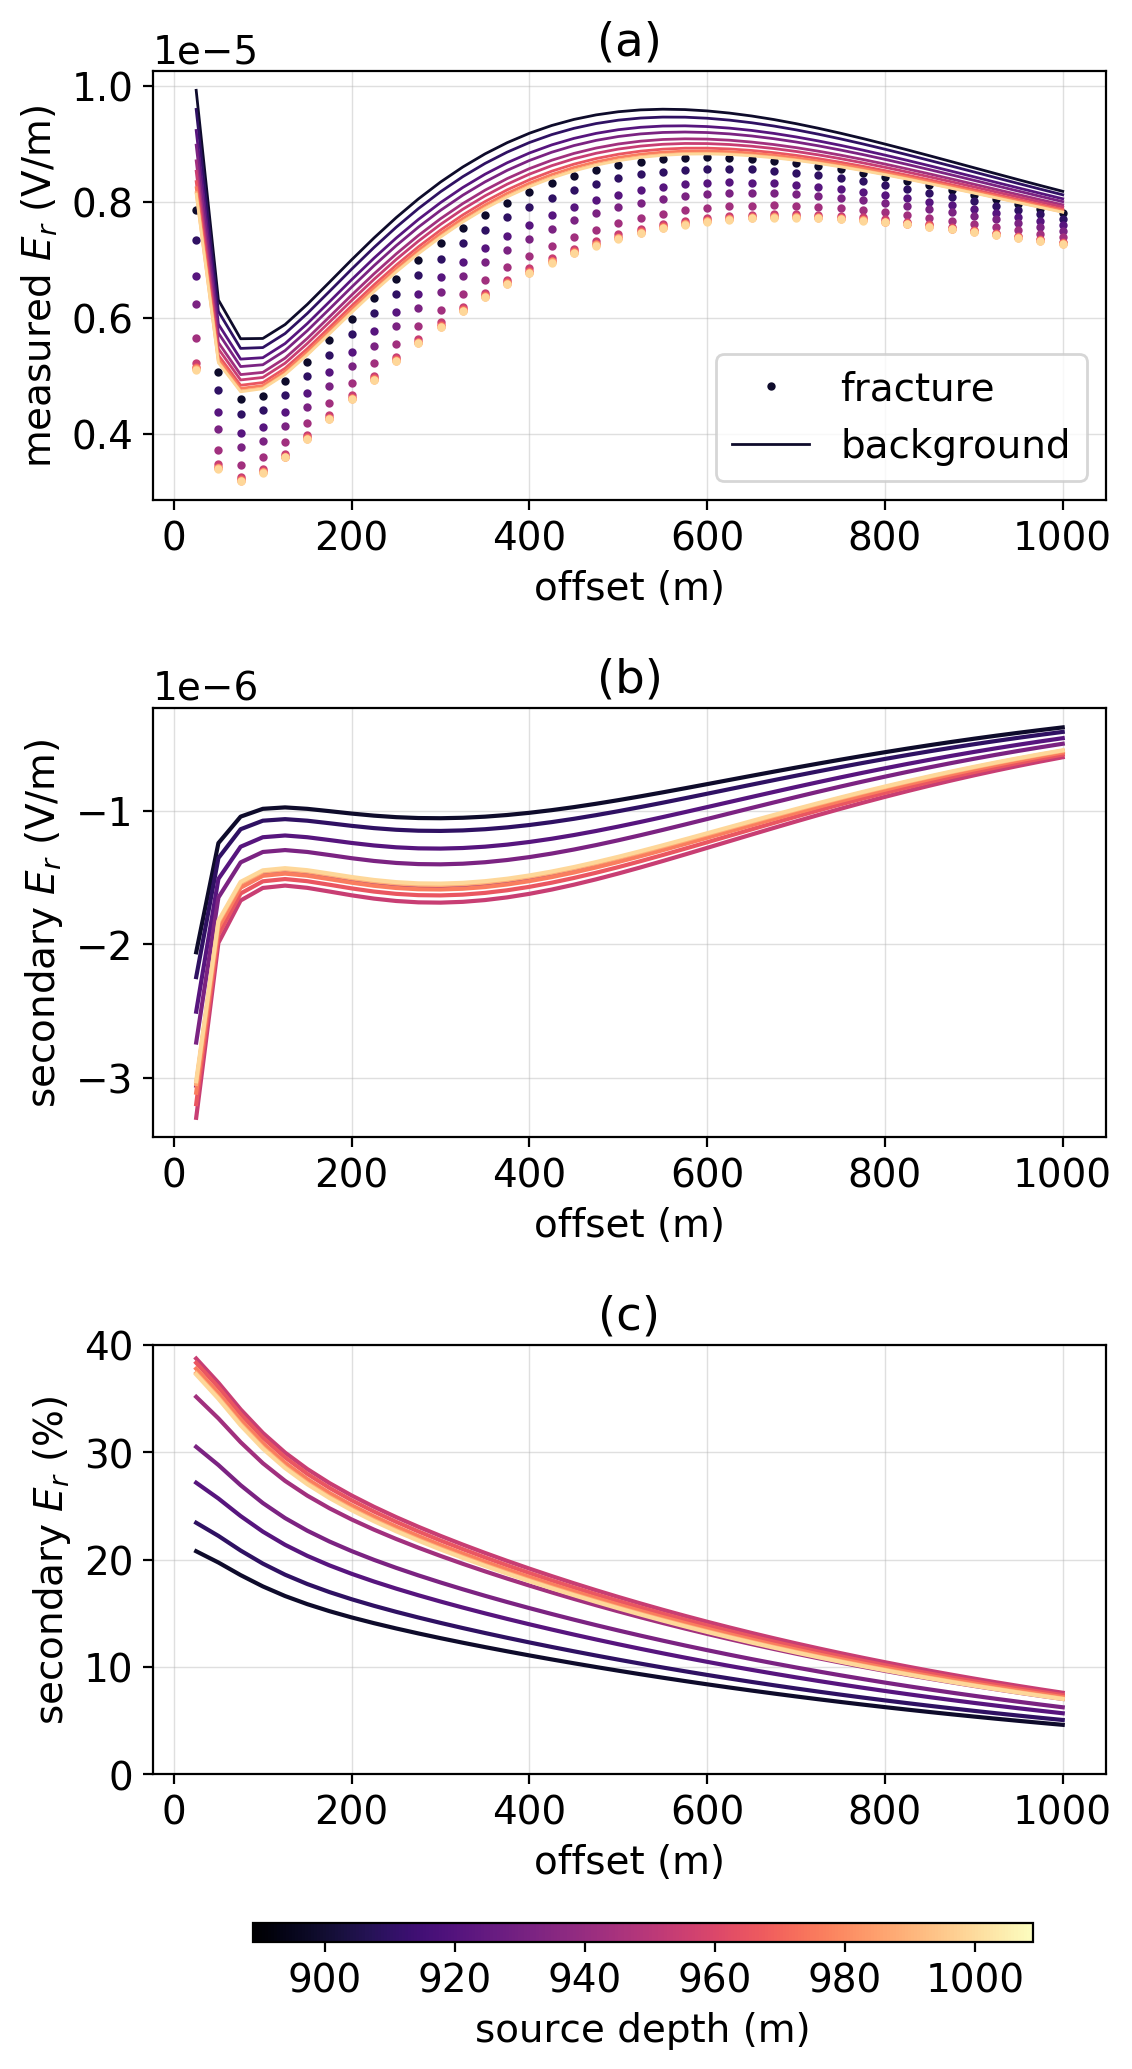

In [47]:
ncols = 2 if include_obswell else 1
fig, ax = plt.subplots(3, ncols, figsize=(ncols*6, 3*3.25), dpi=200)
plot_data(
    data_dict["fracture"]["data_x"], data_dict["background"]["data_x"],
    True, label_obs="fracture", label_pred="background", plot_style="plot",
    fig=fig, ax=ax[:, 0] if include_obswell else ax, reverse_difference=True
)

ax[2].set_ylim([0, 40])

if include_obswell:
    plot_data(
        data_dict["fracture"]["data_z"], data_dict["background"]["data_z"],
        True, label_obs="fracture", label_pred="background", plot_style="plot",
        fig=fig, x=ax[:, 1], component="z"
    )

plt.tight_layout()
# fig.savefig('../figures/dc_casing_initial_data', bbox_inches="tight")

In [48]:
def plot_inversion(dpred, mapping, mrec, xlim=95*np.r_[-1, 1], ylim=[-1100, -800], clim=None, plot_well=True):
    
    fig = plt.figure(figsize=(13, 8), dpi=200)
    ax0 = plt.subplot2grid((3, 7), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
    ax2 = plt.subplot2grid((3, 7), (2, 0), colspan=3)
    ax3 = plt.subplot2grid((3, 7), (0, 3), rowspan=3, colspan=4)
    # ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

    # plot data
    plot_data(
        data_dict["fracture"]["data_x"], wrangle_data(dpred, "x"), ax=[ax0, ax1, ax2], plot_percentage=True)

    ax1.set_ylabel("difference $E_r$")
    ax2.set_ylabel("difference $E_r$ (%)")

    # plot model
    
    if clim is None:
        clim = [np.min([sigma_back, np.exp(mrec).min()]) , np.exp(mrec).max()]
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * mrec, ax=ax3, pcolorOpts={'norm':LogNorm()}, 
        clim=clim
    )
    ax3.set_title("(d)")
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax3.set_aspect(1)
    ax3.set_ylabel("z(m)")
    ax3.set_xlabel("x(m)")
    out_rec[-1].set_label("conductivity (S/m)")

    ax3.plot(
        model.target_radius[1]*np.r_[-1, -1, 1, 1, -1], 
        model.target_z[[0, 1, 1, 0, 0]],
        color='w'
    )
    
    if plot_well is True:
        ax3.plot(
            np.r_[0., 0], model.casing_z, color=[0.7, 0.7, 0.7]
        )

    plt.tight_layout()

    return fig, [ax0, ax1, ax2, ax3], out_rec

## Set up an inversion

In [49]:
STD = 0.01
EPS = 1e-9
CHIFACT = 0.05

In [50]:
# Construct mapping
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
mapping = ExpMap * InjectInactiveCells

In [51]:
def get_prob_survey(mapping):
    prob_inv = DC.Problem3D_CC(
        mesh, sigmaMap=mapping, bc_type='Dirichlet', Solver=Pardiso
    )
    survey_inv = DC.Survey(src_list)
    prob_inv.pair(survey_inv)
    
#     d = discretize.utils.mkvc(np.vstack(data_dict["fracture"]))
    survey_inv.dobs = data_dict["fracture"]["data"]
    survey_inv.std = STD
    survey_inv.eps = EPS
    
    return prob_inv, survey_inv

In [52]:
prob_inv, survey_inv = get_prob_survey(mapping)

Homogeneous Dirichlet is the natural BC for this CC discretization.


## Plot the sensitivity

In [53]:
from matplotlib import colors

In [54]:
prob_inv.model = np.ones((~ind_inactive).sum())*sigma_back
J_l2_m0 = prob_inv.getJ(np.ones((~ind_inactive).sum())*sigma_back)
                        
prob_inv.model = np.log(model.sigma(mesh)[~ind_inactive])
J_l2_target = prob_inv.getJ(np.log(model.sigma(mesh)[~ind_inactive]))

In [55]:
def plot_sensitivity(J, xlim=100*np.r_[-1, 1], ylim=np.r_[-1200, 0], clim=None, ax=None, show_cb=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
#     Jlist = [J.sum(0) for J in Jlist]
    if clim is None:
        Jmax = 1e-2*np.abs(J.max())
#         Jmax = 1e-2*np.abs(J.max())
        clim = Jmax*np.r_[1e-6, 1]
    
#     for a, J in zip(ax, Jlist): 
    out = mesh.plotImage(
        (Maps.InjectActiveCells(mesh, ~ind_inactive, clim[0]) * J)/mesh.vol, 
        ax=ax,
        mirror=True, clim=clim, 
        pcolorOpts={
            "cmap":"pink_r",
            "norm":LogNorm()
        }
    )
    output = (ax, out)
    if show_cb is True:
        cbar = plt.colorbar(out[0], ax=ax, extend="both")
        output += (cbar,)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return output
    

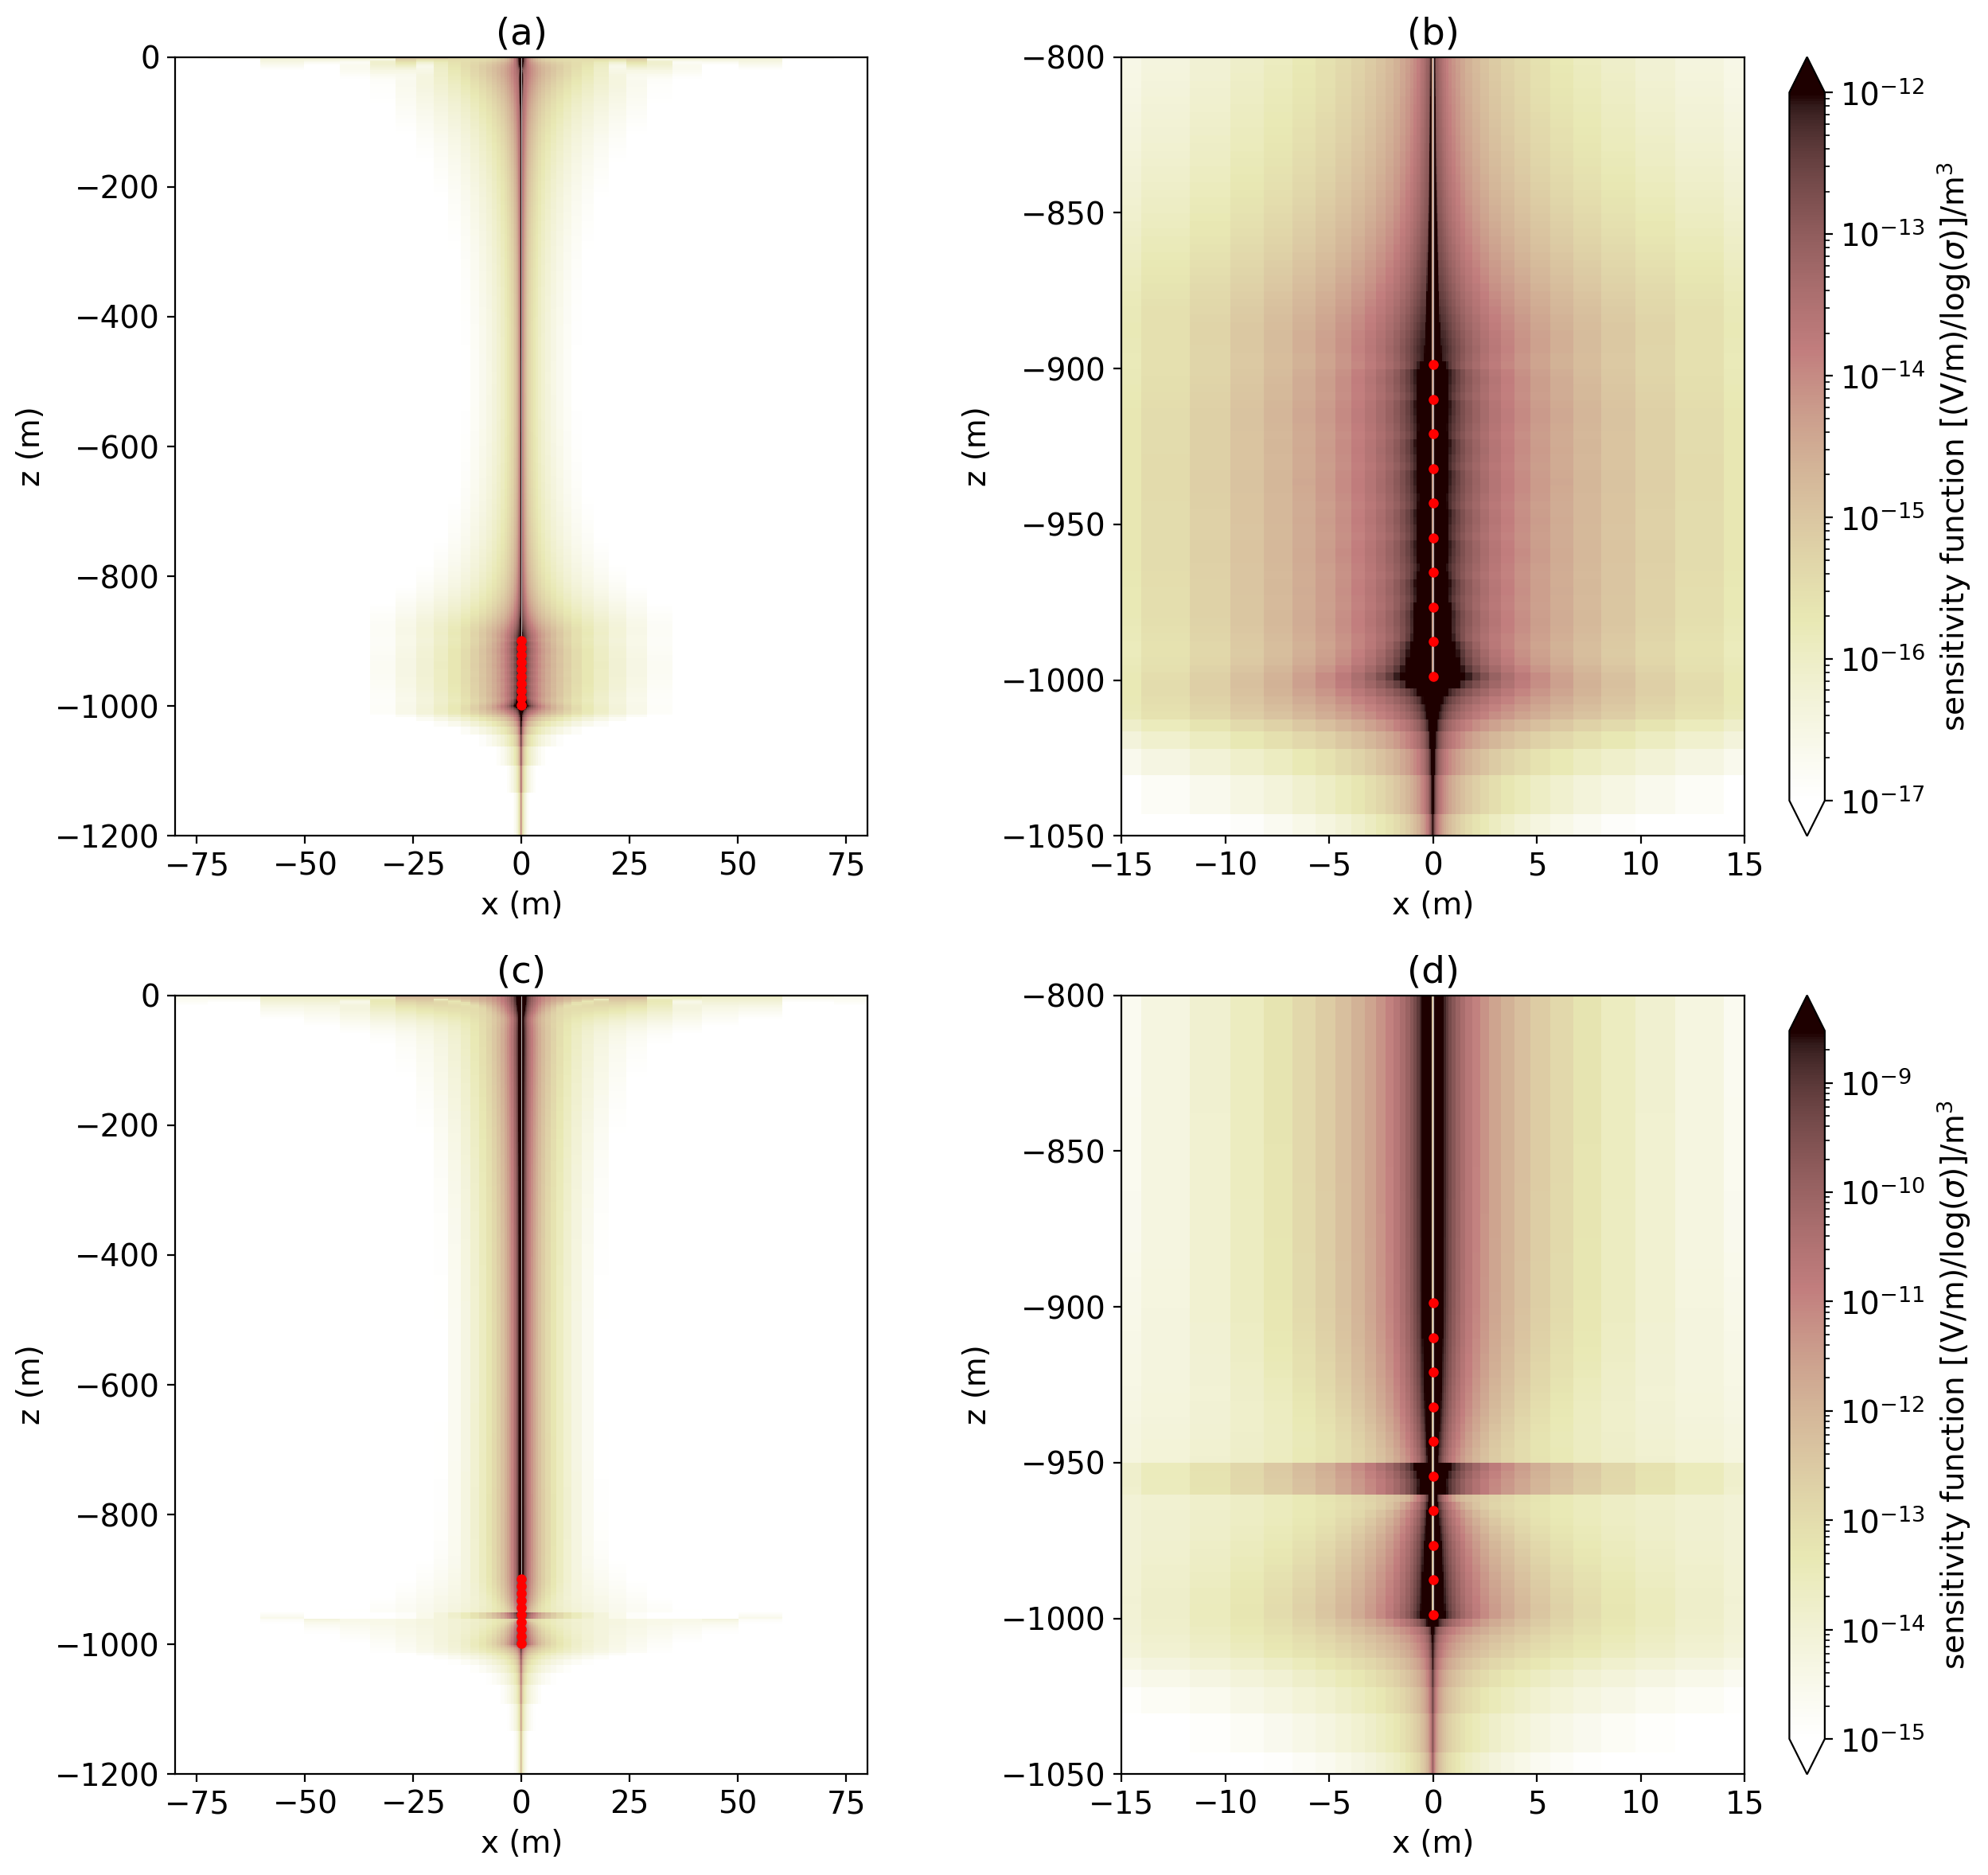

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12), dpi=200)

# J=J_l2_m0
J=J_l2_target

xlims = [80, 15]
ylims = [np.r_[-1200, 0], np.r_[-1050, -800]]
clims = [np.r_[1e-17, 1e-12], np.r_[1e-15, 3e-9]]

# clim = np.r_[1e-17, 1e-10]

for i, J, clim in zip([0, 1], [J_l2_m0, J_l2_target], clims):
    
    jplt = np.sqrt((J**2).sum(0))/mesh.vol[~ind_inactive]
    
    for j, a, xlim, ylim, title in zip([0, 1], ax[i, :], xlims, ylims, ascii_lowercase[:2]):
        out = plot_sensitivity(
            jplt, ax=a, 
            xlim=xlim*np.r_[-1, 1], ylim=ylim, 
            clim=clim,
            show_cb=False if j==0 else True
        )

        if j==1:
            out[-1].set_label('sensitivity function [(V/m)/log($\sigma$)]/m$^3$')
    # out = plot_sensitivity(J.sum(0), ax=a, xlim=10*np.r_[-1, 1], ylim = np.r_[-1050, -850])

        a.set_aspect(1.5e-1)
        a.set_xlabel('x (m)')
        a.set_ylabel('z (m)')
        a.plot(np.r_[0., 0], model.casing_z, color=[0.7, 0.7, 0.7], lw=0.4)
        a.plot(np.zeros_like(src_a[:, 2]), src_a[:, 2], 'ro', ms=3.5)

[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

plt.tight_layout()

fig.savefig('../figures/casing_sensitivity', dpi=200, bbox_inches="tight")

## Run the inversion

In [57]:
regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg = Regularization.Tikhonov(regmesh, alpha_s=1e-3, alpha_x=1, indActive=~ind_inactive)
dmis = DataMisfit.l2_DataMisfit(survey_inv)
opt = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
# opt = Optimization.ProjectedGNCG(maxIterCG=10, maxIter=10, remember='xc', lower=np.log(sigma_back), stepOffBoundsFact=1e-2)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory="smooth_inversion"),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)

In [58]:
directives[-2].directory

'smooth_inversion'

In [59]:
m0 = np.log(sigma_back * np.ones(mapping.nP)) + 1e-10

In [60]:
%%time
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: 'smooth_inversion/###-InversionModel-2018-11-08-19-04.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.54e+00  4.08e+03  0.00e+00  4.08e+03    1.30e+03      0              
   1  1.54e+00  1.67e+02  1.80e+00  1.70e+02    1.72e+02      0              
   2  1.54e+00  4.87e+01  2.71e+00  5.29e+01    1.24e+01      0   Skip BFGS  
   3  1.93e-01  1.38e+01  4.62e+00  1.47e+01    1.41e+01      0   Skip BFGS  
   4  1.93e-01  1.04e+01  8.59e+00  1.21e+01    3.83e+01      0              
------------------------- ST

saving ../figures/dc_smooth_inversion_5e-02.png


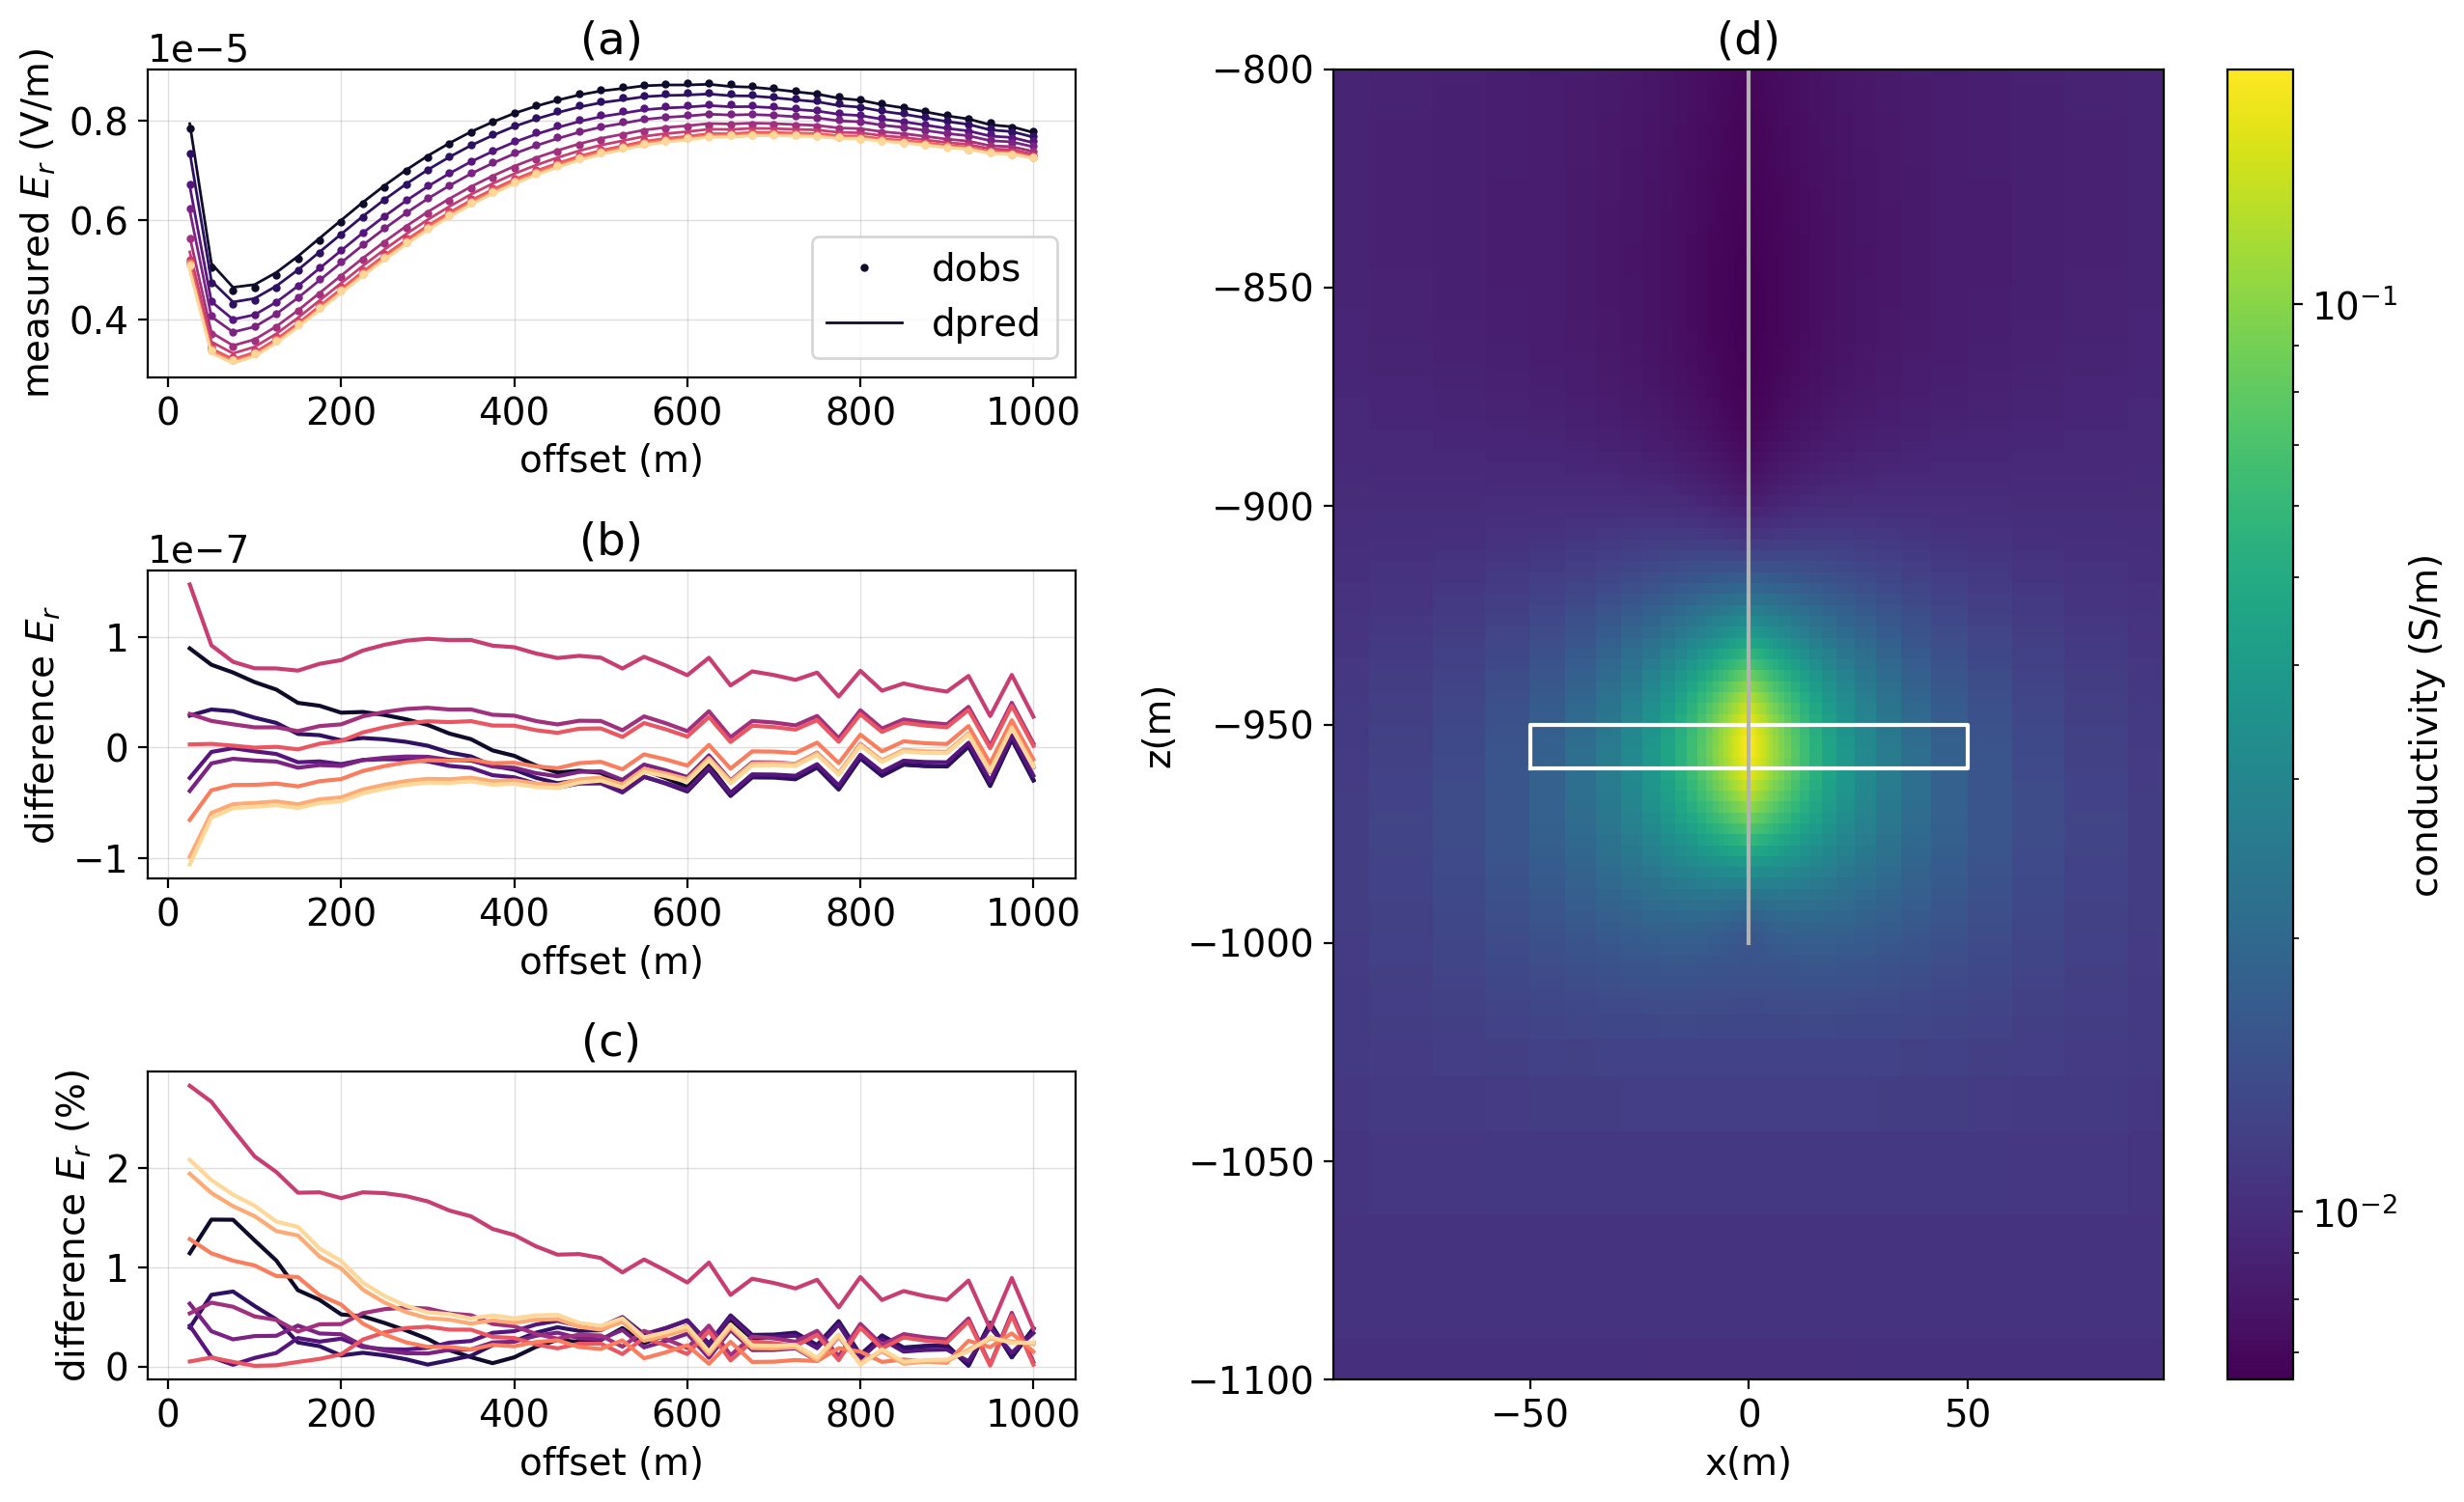

In [61]:
fig, ax, out = plot_inversion(invProb.dpred, mapping, mrec)

if reg.alpha_x == 1:
    if isinstance(opt, Optimization.ProjectedGNCG):
        name = '../figures/dc_smooth_inversion_{:1.0e}_bounded'.format(CHIFACT)
        
    else: 
        name = '../figures/dc_smooth_inversion_{:1.0e}'.format(CHIFACT)
else:
    if isinstance(opt, Optimization.ProjectedGNCG):
        name = '../figures/dc_smooth_inversion_{:1.0e}_alpha_{:1.0f}_bounded'.format(CHIFACT, reg.alpha_x)
    else: 
        name = '../figures/dc_smooth_inversion_{:1.0e}_alpha_{:1.0f}'.format(CHIFACT, reg.alpha_x)

print("saving {}.png".format(name))
fig.savefig(name, dpi=200)

## Parametric inversion

- block in a halfspace
- ellipsoid? 

In [62]:
# mapping_parametric
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=5e-2, p=4)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)

# indActiveX0Z0 = np.ones(ParametricBlock.nP, dtype=bool)
# indActiveX0Z0[[2, 4]] = [False]*2
# InjectX0Z0 = InjectX0 = Maps.InjectActiveCells(
#     discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0Z0,
#     valInactive=np.r_[0., np.mean(model.target_z)]
# )

# mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0Z0
mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0

In [63]:
experiment = 3

if experiment == 1: 
    m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 20., -980, 5.]
    directory = "parametric_voxel1_10r"
elif experiment == 2:
    m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 20., model.target_z.mean(), 5.]
    directory = "parametric_voxel2__10r"
elif experiment == 3:
    m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 20., model.target_z.mean(), 10.]
    directory = "parametric_voxel2_dz10_10r"
elif experiment == 4:
    m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 20., 10.]
    directory = "parametric_voxel2_dz10_fixedz0"
    indActiveX0Z0 = np.ones(ParametricBlock.nP, dtype=bool)
    indActiveX0Z0[[2, 4]] = [False]*2
    InjectX0Z0 = Maps.InjectActiveCells(
        discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0Z0,
        valInactive=np.r_[0., np.mean(model.target_z)]
    )

    mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0Z0
elif experiment == 5:
    m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 150., model.target_z.mean(), 5.]
    directory = "parametric_voxel2_large_r"
    
    

In [64]:
np.mean(model.target_z)

-955.0

In [65]:
mapping_parametric.test(m0_parametric)

Testing ComboMap[ComboMap[ComboMap[ExpMap(42432,42432) * InjectActiveCells(42432,38816)](42432,38816) * ParametricBlock(38816,6)](42432,6) * InjectActiveCells(6,5)](42432,5)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.013e-01     2.674e-03      nan
 1   1.00e-02    1.037e-02     2.716e-05      1.993
 2   1.00e-03    1.039e-03     2.720e-07      1.999
 3   1.00e-04    1.039e-04     2.720e-09      2.000
========================= PASS! =========================
Awesome, Lindseyjh, just awesome.



True

Text(0.5, 1.0, 'starting')

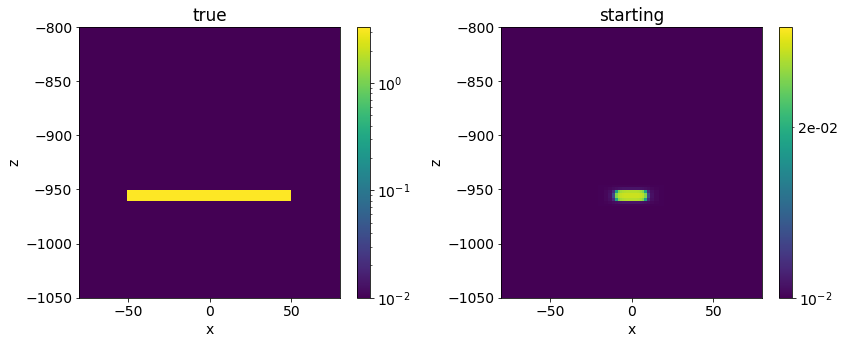

In [66]:
out = plot_models(m0_parametric, mapping_parametric, clim=[np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())])
out[0][1].set_title("starting")

In [67]:
prob_parametric, survey_parametric = get_prob_survey(mapping_parametric)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [68]:
m_sens = np.r_[np.log(sigma_back), np.log(sigma_frac), model.target_radius[1], model.target_z.mean(), model.target_z[1] - model.target_z[0]]
# m_sens = m0_parametric
prob_parametric.model = m_sens
J = prob_parametric.getJ(m_sens)

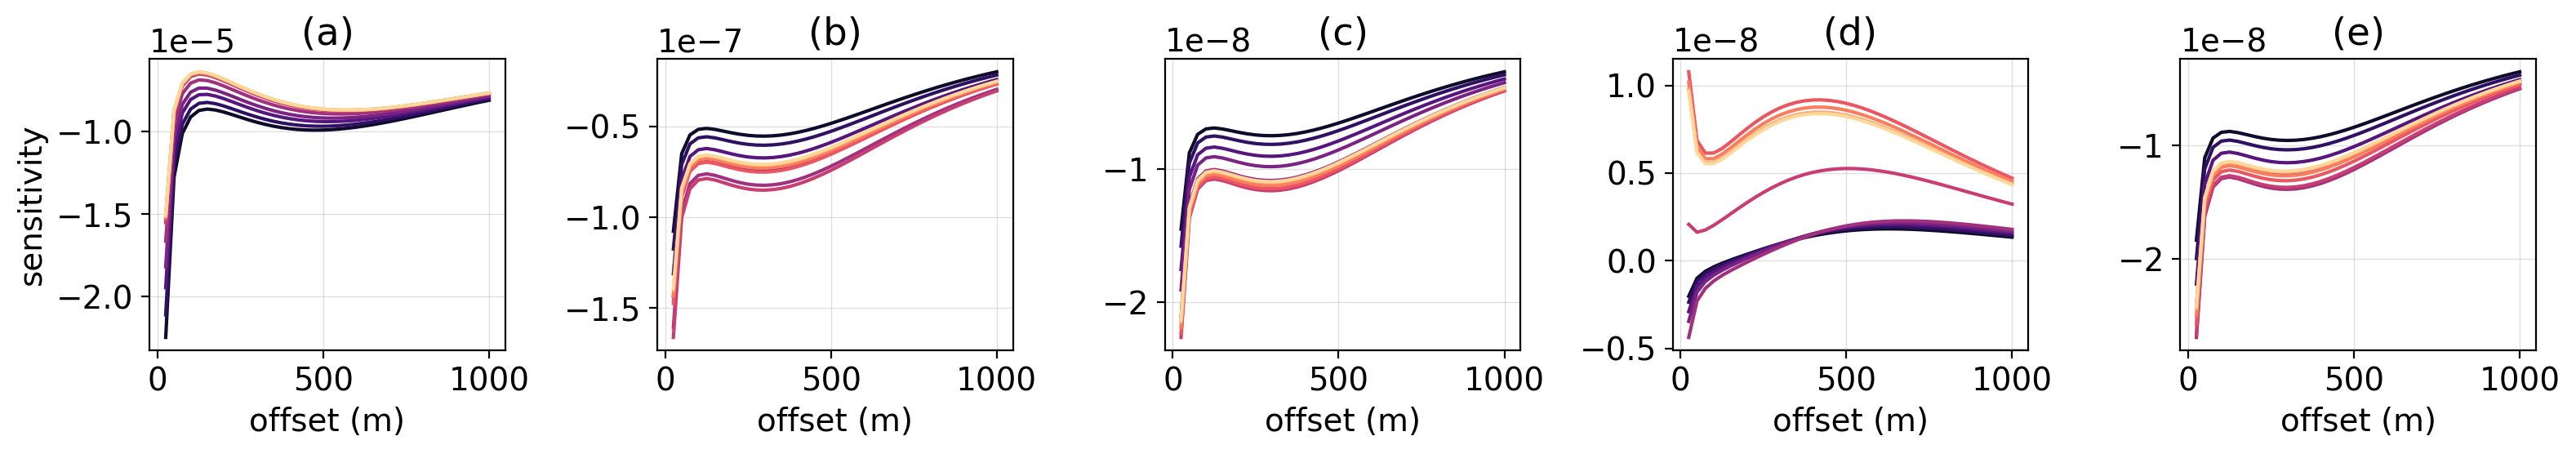

In [69]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3), dpi=200)

for i, a in enumerate(ax):
    Jplt = wrangle_data(J[:,i])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_xlabel('offset (m)')
    a.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_ylabel('sensitivity')
        
    for j in range(len(src_list)):
        color = scalar_map.to_rgba(-z_locs[j])
        a.plot(rx_x, Jplt[:, j], color=color)

plt.tight_layout()

In [70]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([mapping_parametric.nP]))
dmis_parametric = DataMisfit.l2_DataMisfit(survey_parametric)
opt_parametric = Optimization.InexactGaussNewton(maxIterCG=15, maxIter=30, remember='xc')
invProb_parametric = InvProblem.BaseInvProblem(dmis_parametric, reg_parametric, opt_parametric, beta=0)
directives = [
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory=directory),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_parametric = Inversion.BaseInversion(invProb_parametric, directiveList=directives)

In [71]:
%%time
mrec_parametric = inv_parametric.run(m0_parametric)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: 'parametric_voxel2_dz10_10r/###-InversionModel-2018-11-08-19-05.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  3.43e+03  4.71e+06  3.43e+03    5.67e+04      0              
   1  0.00e+00  2.55e+02  4.71e+06  2.55e+02    4.30e+03      0              
   2  0.00e+00  2.26e+02  4.71e+06  2.26e+02    5.12e+01      0   Skip BFGS  
   3  0.00e+00  7.29e+01  4.71e+06  7.29e+01    2.81e+02      1   Skip BFGS  
   4  0.00e+00  7.28e+01  4.71e+06  7.28e+01    1.12e+01      0              
   5  0.00e+00  5.

In [72]:
def print_parametric(m): 
    model_info = (
        "sigma back   : {:1.2e} S/m\n"
        "sigma target : {:1.2e} S/m\n"
        "target radius: {:1.2f} m\n"
        "target top   : {:1.2f} m\n"
        "target_bottom: {:1.2f} m\n"
    )
    if len(m) == 5: 
        print(
            model_info.format(
                np.exp(m[0]), np.exp(m[1]), 
                m[2]/2,
                m[3] + m[4]/2, 
                m[3] - m[4]/2
            )
        )
    elif len(m) == 4:
        print(
           model_info.format(
                np.exp(m[0]), np.exp(m[1]), 
                m[2]/2,
                InjectX0Z0.valInactive[4] + m[3]/2, 
                InjectX0Z0.valInactive[4] - m[3]/2
            )
        )

In [73]:
print_parametric(m0_parametric)

sigma back   : 1.00e-02 S/m
sigma target : 3.00e-02 S/m
target radius: 10.00 m
target top   : -950.00 m
target_bottom: -960.00 m



In [74]:
print_parametric(mrec_parametric)
# np.exp(mrec_parametric[[0, 1]])

sigma back   : 1.01e-02 S/m
sigma target : 7.86e+00 S/m
target radius: 24.91 m
target top   : -947.51 m
target_bottom: -971.68 m



In [75]:
model.sigma_target

3.306452089817292

In [76]:
mrec_parametric

array([  -4.5931478 ,    2.06189407,   49.82774384, -959.59559507,
         24.16232686])

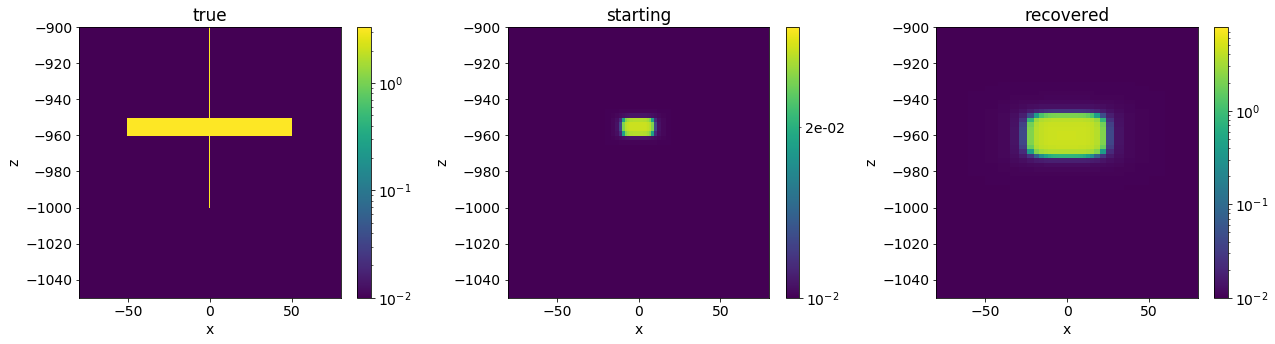

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -900]
clim_start = [np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())]
clim_rec = [np.min(np.r_[sigma_back, np.exp(mrec_parametric[:2].min())]), np.exp(mrec_parametric[:2].max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_initial = phys_props_dict[key].plot_prop(
    mapping_parametric * m0_parametric, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim_start
)
out_rec = phys_props_dict[key].plot_prop(
    mapping_parametric * mrec_parametric, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim_rec
)

for a, title in zip(ax, ["true", "starting", "recovered"]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [78]:
def block_plotting_coordinates(x, dx, z, dz):
    return (
        np.r_[x-dx/2, x-dx/2, x+dx/2, x+dx/2, x-dx/2], 
        np.r_[z-dz/2, z+dz/2, z+dz/2, z-dz/2, z-dz/2]
    )

In [79]:
# directory = "parametric_voxel2_dz10"
directory = directives[-2].directory
parametric_models = [
    np.load(directory + '/' + f) for f in
    sorted(os.listdir(directory)) if f.endswith('.npy')
]

In [80]:
len(parametric_models)

16

In [81]:
print_parametric(parametric_models[-1])

sigma back   : 1.01e-02 S/m
sigma target : 7.86e+00 S/m
target radius: 24.91 m
target top   : -947.51 m
target_bottom: -971.68 m



In [82]:
def plot_parametric(it=0):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    m = parametric_models[it]
    clim_rec = [np.min(np.r_[sigma_back, np.exp(m[:2].min())]), np.exp(m[:2].max())]

    out_rec = phys_props_dict[key].plot_prop(
        mapping_parametric * m, 
        pcolorOpts={'norm':LogNorm()}, clim=clim_rec, ax=ax
    )
    block_true = block_plotting_coordinates(
        0, model.target_radius[1]*2, model.target_z.mean(), model.target_z[1] - model.target_z[0]
    )
    block = block_plotting_coordinates(
        0, m0_parametric[2], m0_parametric[3] if len (m0_parametric) == 5 else InjectX0Z0.valInactive[4], 
        m0_parametric[4] if len(m0_parametric) == 5  else m0_parametric[3]
    )
    ax.plot(block_true[0], block_true[1], color="w", ls="-")
    ax.plot(block[0], block[1], color="w", ls="--")
    ax.set_xlim(80*np.r_[-1, 1])
    ax.set_ylim([-1100, -800])
    
    plt.show()

In [83]:
ipywidgets.interact(
    plot_parametric, 
    it = ipywidgets.IntSlider(min=0, max=len(parametric_models)-1, val=0)
)

interactive(children=(IntSlider(value=0, description='it', max=15), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_parametric(it=0)>

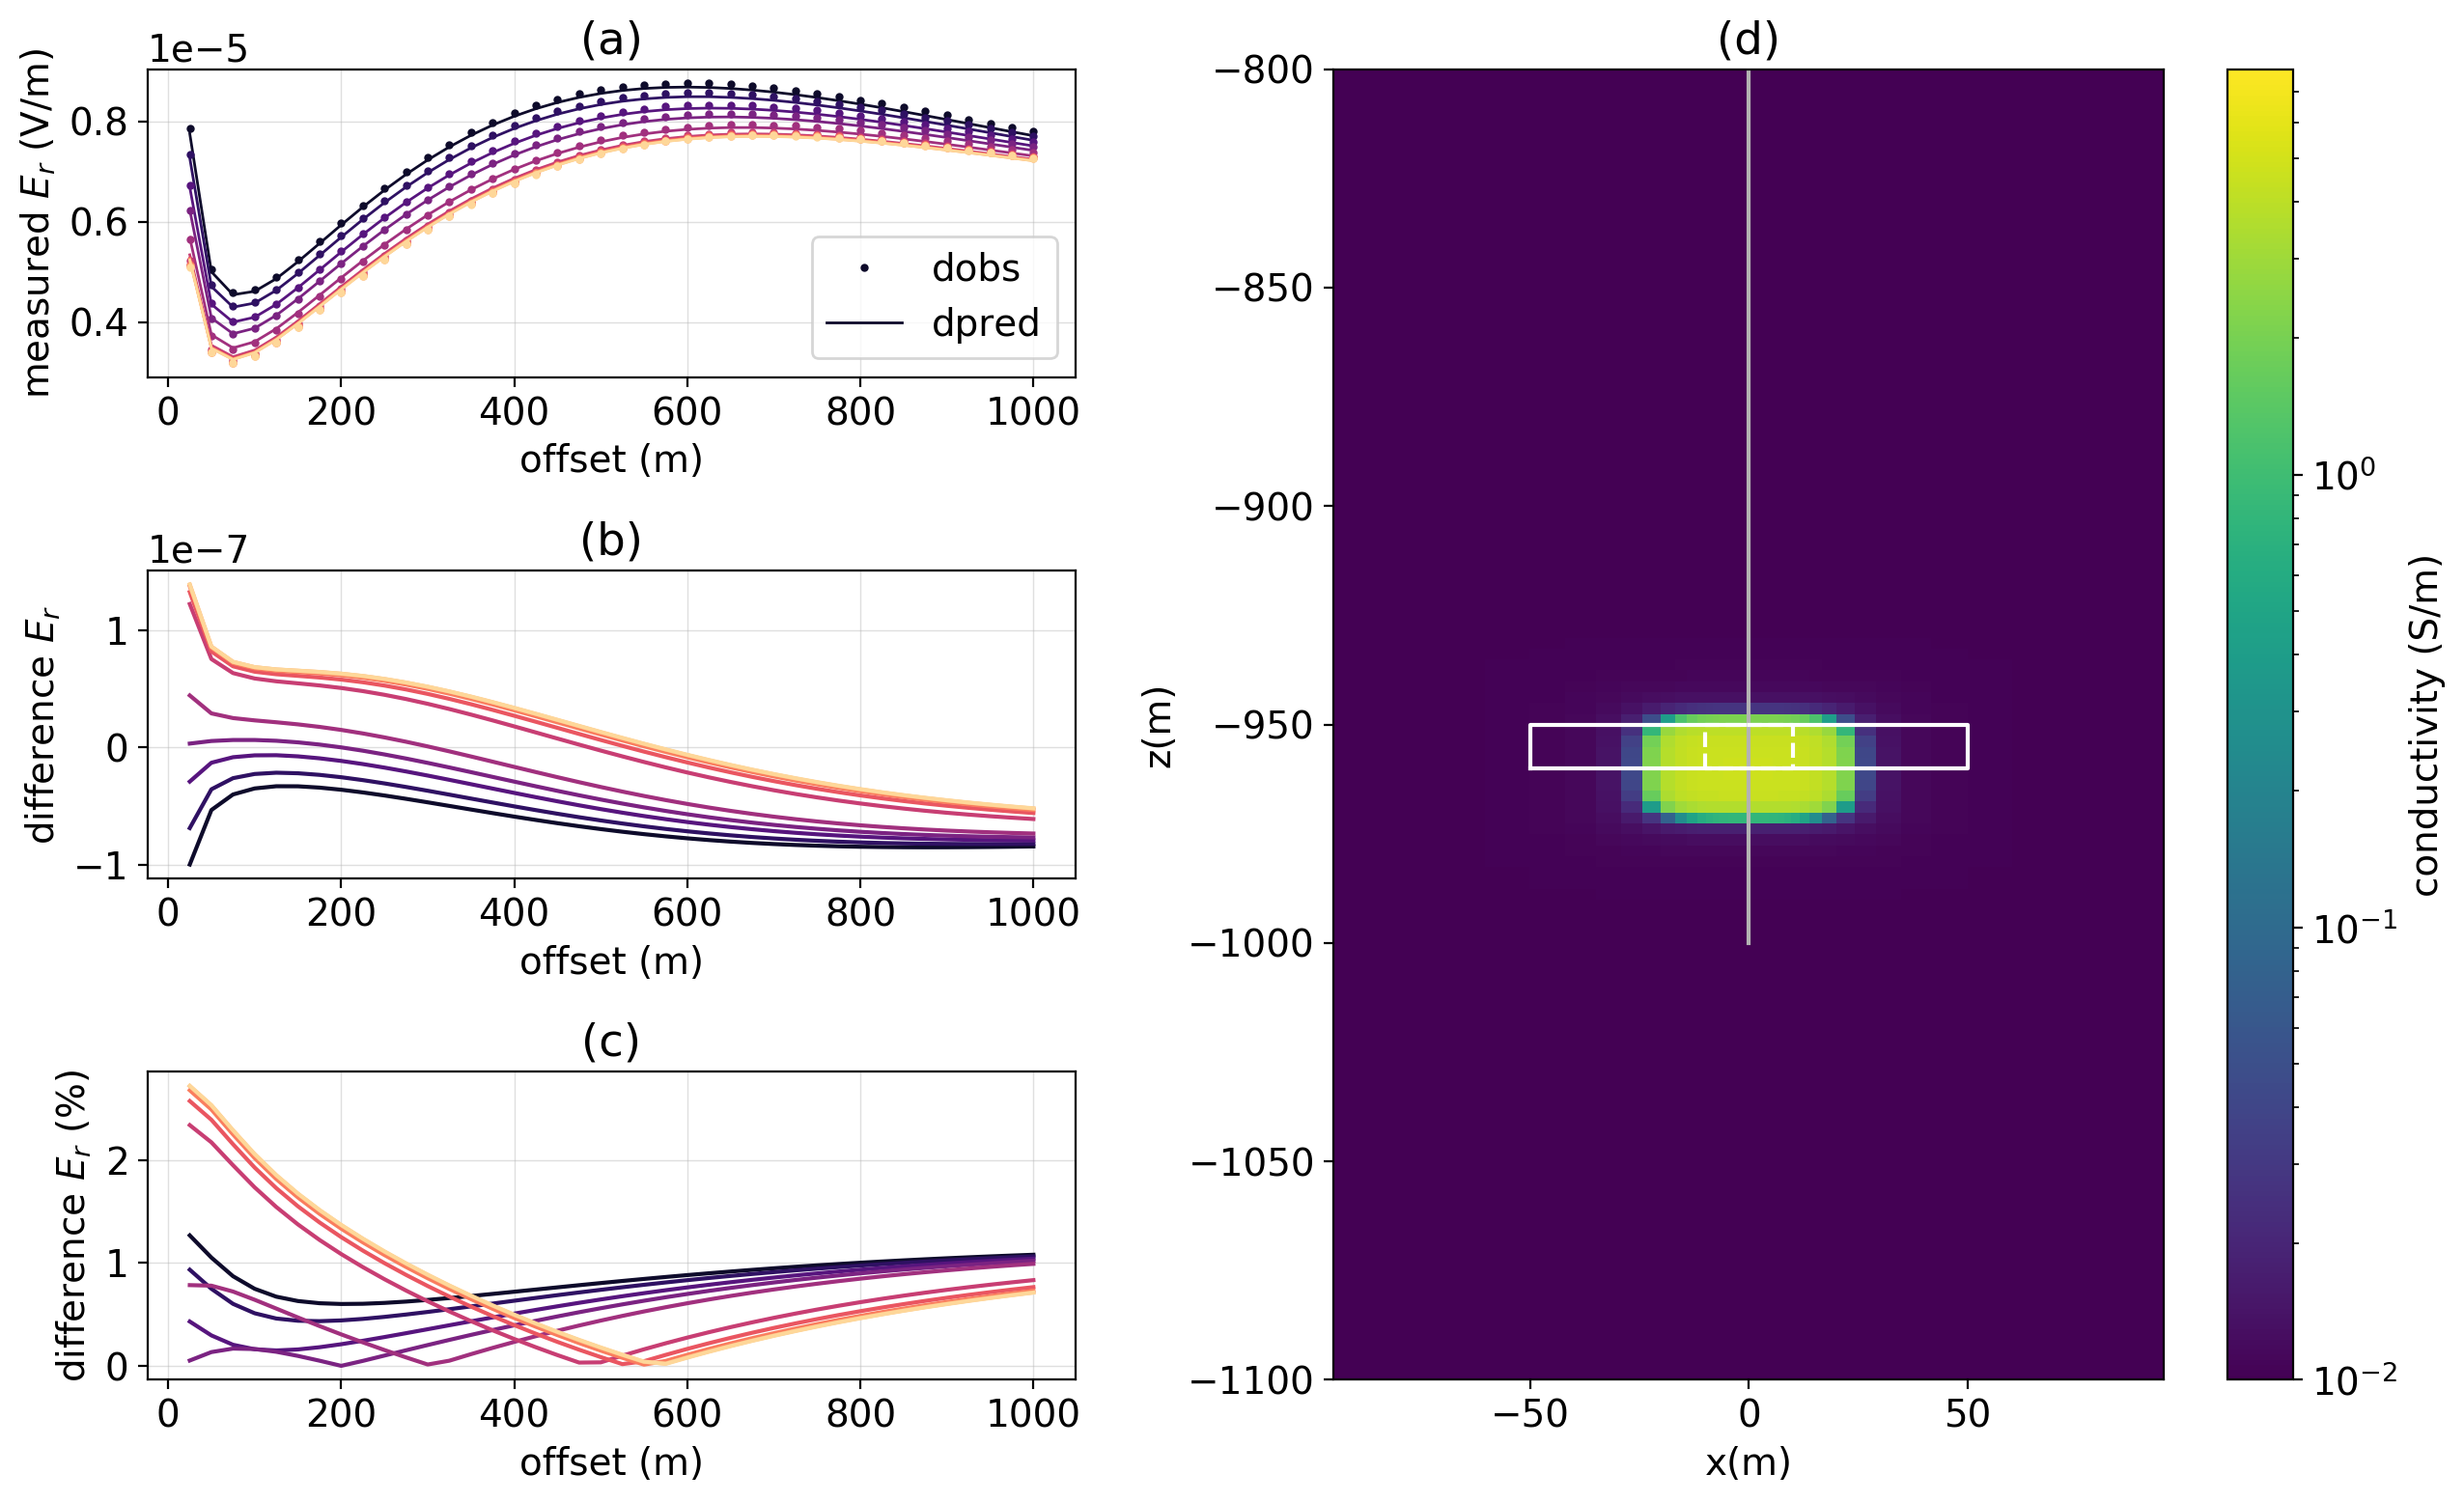

In [84]:
fig, ax, out = plot_inversion(
    invProb_parametric.dpred, mapping_parametric, mrec_parametric, 
    clim=[
        np.min(np.r_[sigma_back, np.exp(mrec_parametric[:2]).min()]),
        np.max(np.exp(mrec_parametric[:2]))
    ]
)
block = block_plotting_coordinates(
    0, m0_parametric[2], m0_parametric[3] if len (m0_parametric) == 5 else InjectX0Z0.valInactive[4], 
    m0_parametric[4] if len(m0_parametric) == 5  else m0_parametric[3]
) 
ax[3].plot(block[0], block[1], color="w", ls="--")

fig.savefig("../figures/{}".format(directory), dpi=200)


In [85]:
directory

'parametric_voxel2_dz10_10r'

In [86]:
m0_parametric

array([  -4.60517019,   -3.5065579 ,   20.        , -955.        ,
         10.        ])

In [87]:
mrec_parametric

array([  -4.5931478 ,    2.06189407,   49.82774384, -959.59559507,
         24.16232686])

## SCEMT mapping

In [88]:
n = 100

scemt = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=n
)

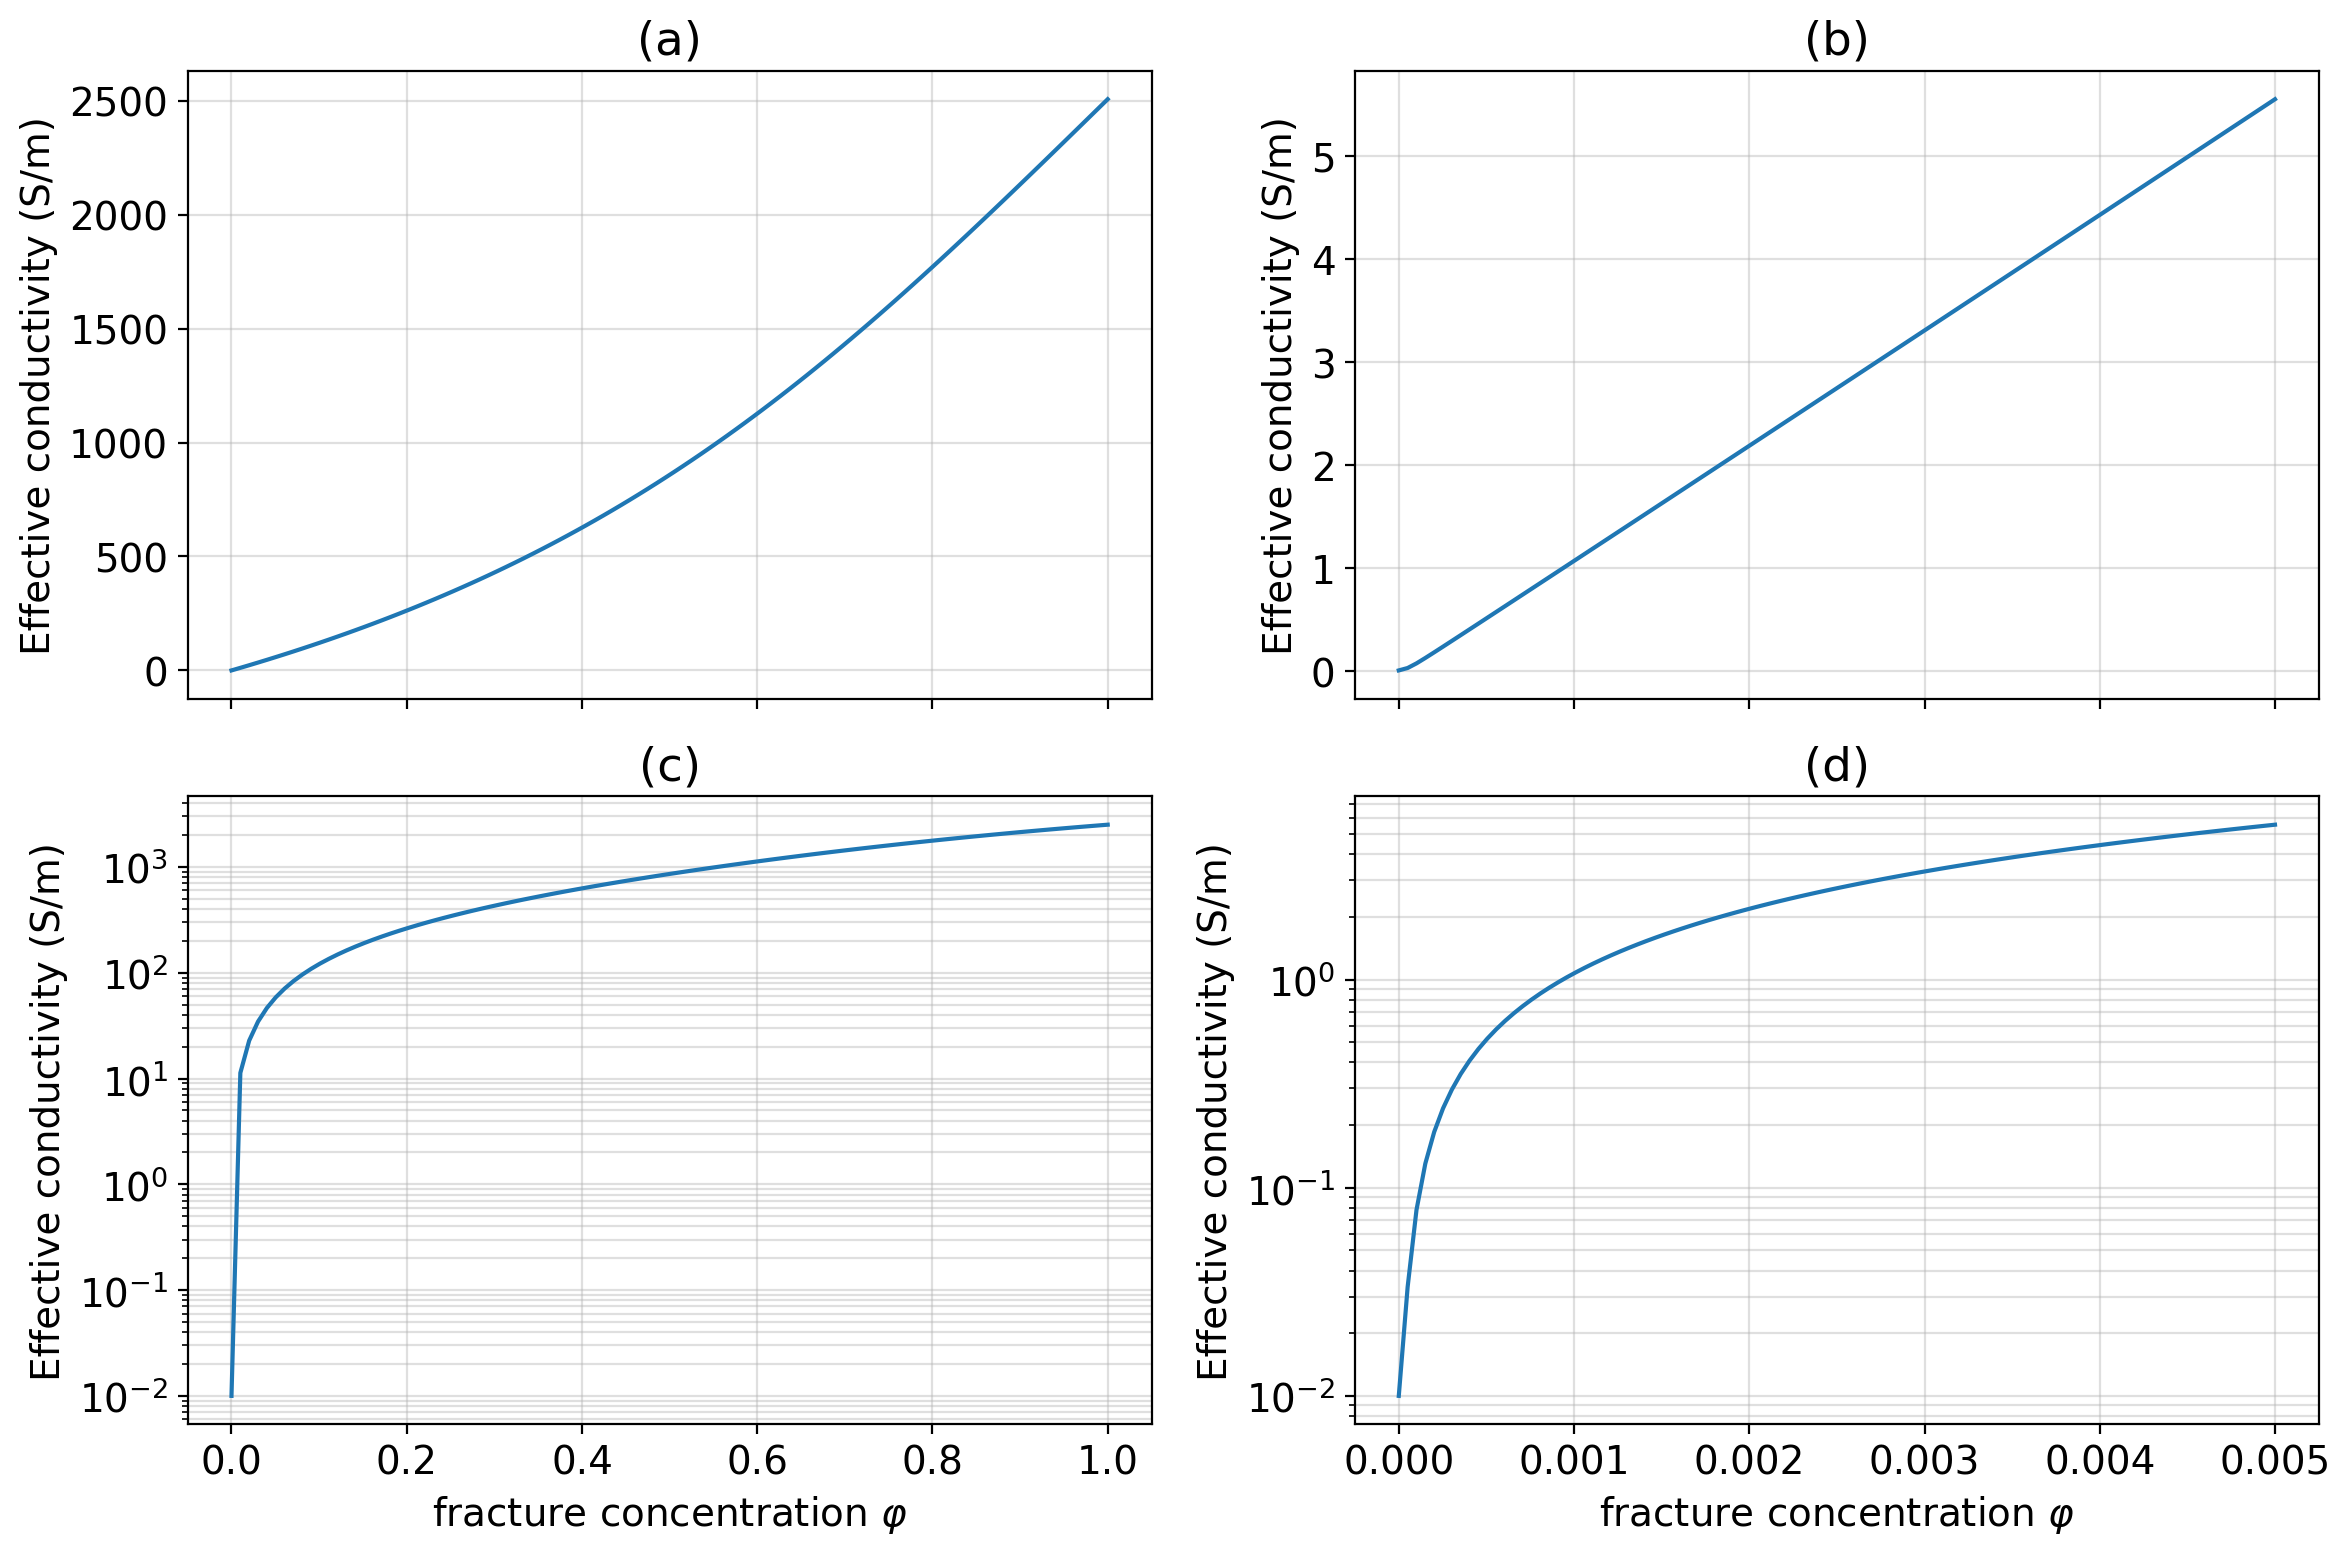

In [89]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=200)
ax = ax.flatten()

phi = np.linspace(0, 1, n)

ax[0].plot(phi, scemt*phi)
ax[2].semilogy(phi, scemt*phi)

phi2 = np.linspace(0, 0.005, n)
ax[1].plot(phi2, scemt*phi2)
ax[3].semilogy(phi2, scemt*phi2)

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_ylabel("Effective conductivity (S/m)")
    
    if i in [0, 1]:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_xlabel('')
        
    else:
        a.set_xlabel('fracture concentration $\\varphi$')
        

plt.tight_layout()

fig.savefig("../figures/scemt_mapping", dpi=200)


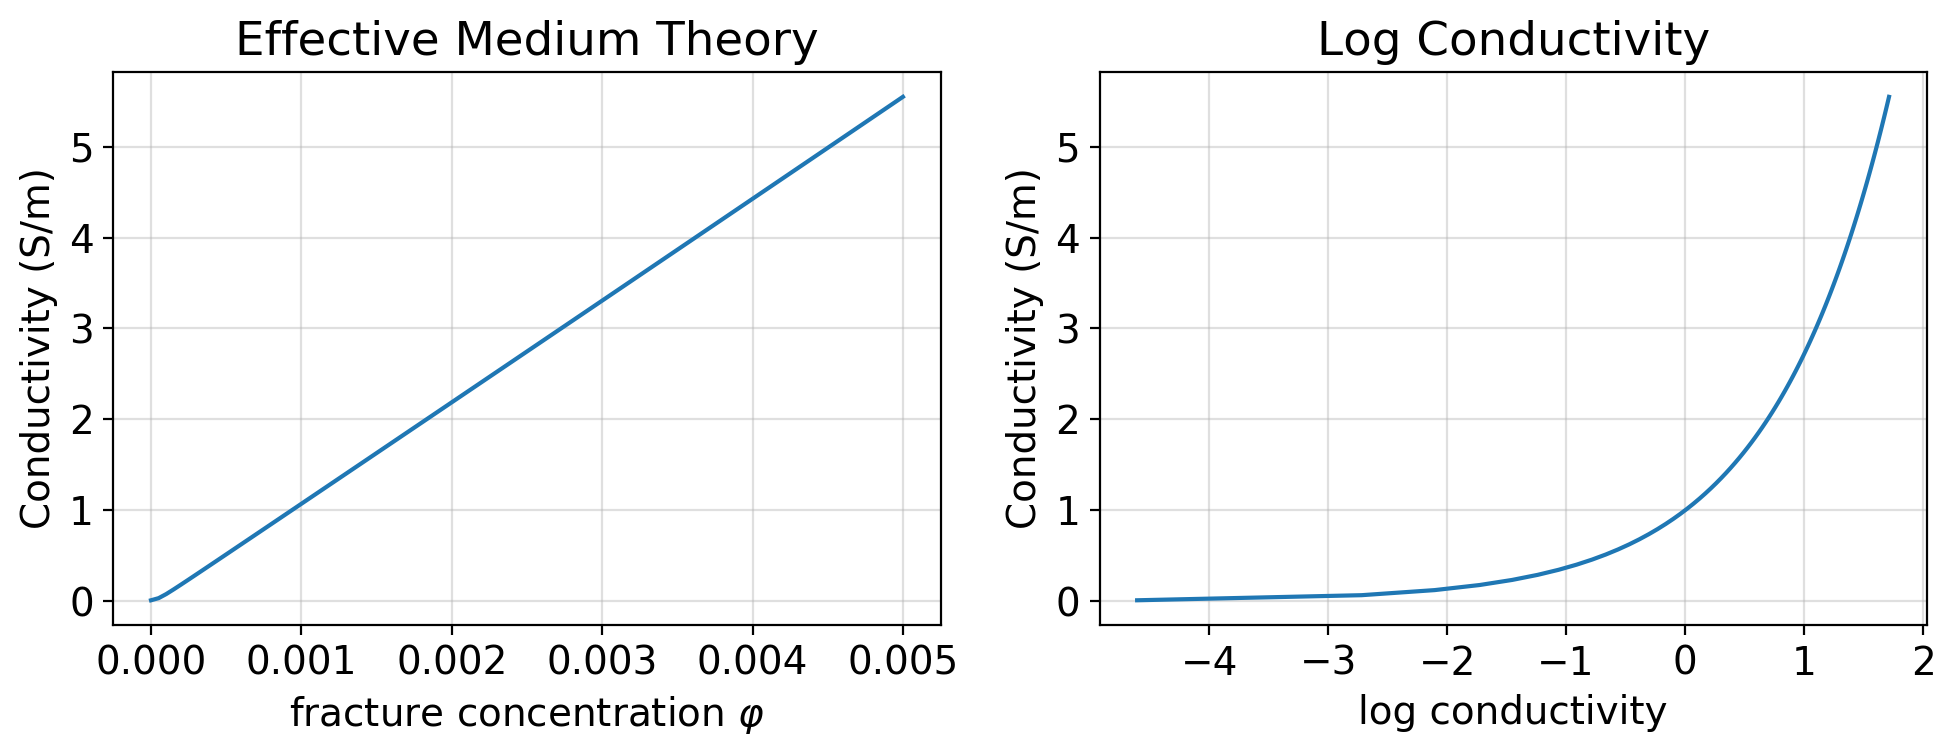

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
ax = ax.flatten()

phi2 = np.linspace(0, 0.005, n)
sig_emt = scemt*phi2
ax[0].plot(phi2, scemt*phi2)
ax[0].set_title("Effective Medium Theory")
ax[0].set_xlabel('fracture concentration $\\varphi$')

sigma2 = np.linspace(sig_emt[0], sig_emt[-1], n)
ax[1].plot(np.log(sigma2), sigma2)
ax[1].set_title("Log Conductivity")
ax[1].set_xlabel('log conductivity')

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
#     a.set_title("({})".format(ascii_lowercase[i]))
    a.set_ylabel("Conductivity (S/m)")
    
#     if i in [0, 1]:
#         a.set_xticklabels(['']*len(a.get_xticklabels()))
#         a.set_xlabel('')
        
#     else:
#         a.set_xlabel('fracture concentration $\\varphi$')
        

plt.tight_layout()

fig.savefig("../figures/scemt_mapping2", dpi=200)


In [81]:
scemt_mapping = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)

In [82]:
phi_true = scemt_mapping.inverse(model.sigma(mesh)[~ind_inactive])

### L2 Inversion with SCEMT mapping

In [83]:
mapping_scemt = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive) * scemt_mapping
mapping_scemt_phi = Maps.InjectActiveCells(mesh, ~ind_inactive, 0)

In [84]:
prob_scemt, survey_scemt = get_prob_survey(mapping_scemt)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [85]:
m0_scemt = 1e-10 + np.zeros(mapping_scemt.nP)

In [86]:
mapping_scemt.test(m0_scemt, dx=0.01*np.random.rand(mapping_scemt.nP))

Testing ComboMap[InjectActiveCells(42432,38816) * SelfConsistentEffectiveMedium(38816,38816)](42432,38816)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.175e+02     9.012e+01      nan
 1   1.00e-02    6.554e+00     3.863e+00      1.368
 2   1.00e-03    3.023e-01     2.888e-02      2.126
 3   1.00e-04    2.770e-02     2.673e-04      2.034
========================= PASS! =========================
Happy little convergence test!



True

In [87]:
prob_scemt.model = m0_scemt
J_scemt_m0 = prob_scemt.getJ(m0_scemt)
                    
prob_scemt.model = np.log(phi_true)
J_scemt_target = prob_scemt.getJ(phi_true)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


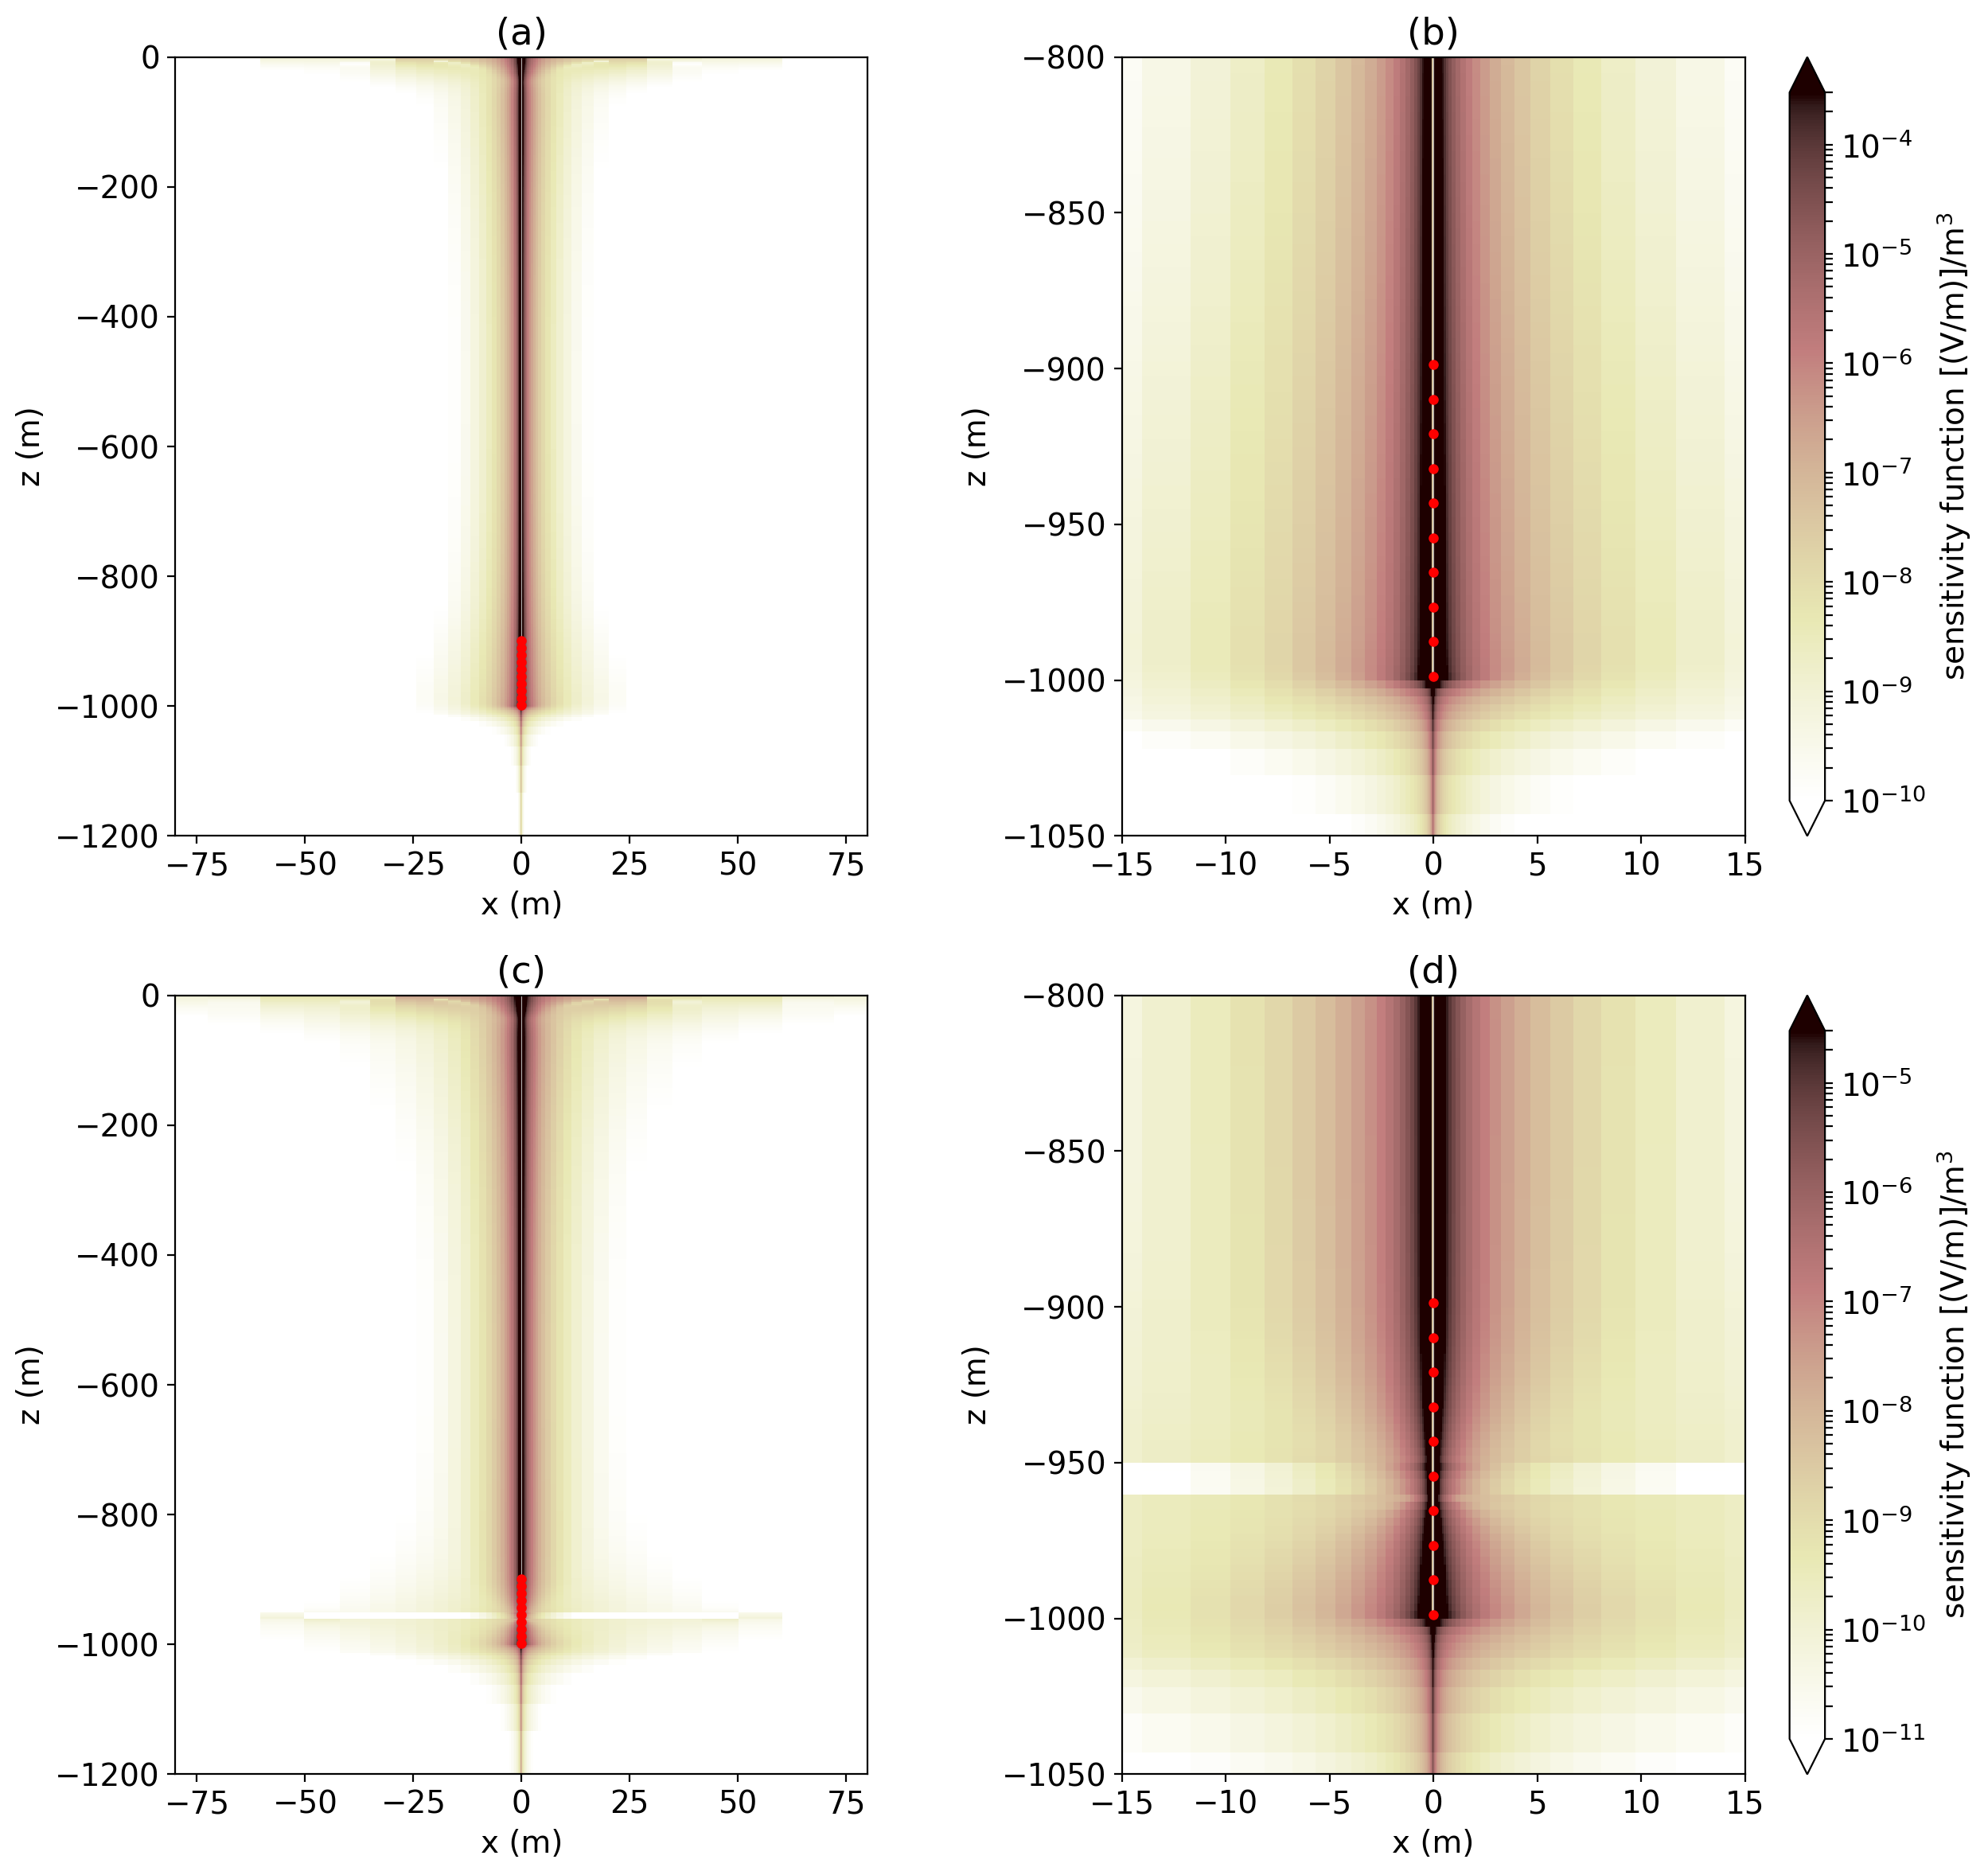

In [88]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12), dpi=200)

xlims = [80, 15]
ylims = [np.r_[-1200, 0], np.r_[-1050, -800]]
clims = [np.r_[1e-10, 3e-4], np.r_[1e-11, 3e-5]]

# clim = np.r_[1e-17, 1e-10]

for i, J, clim in zip([0, 1], [J_scemt_m0, J_scemt_target], clims):
    
    jplt = np.sqrt((J**2).sum(0))/mesh.vol[~ind_inactive]
    
    for j, a, xlim, ylim, title in zip([0, 1], ax[i, :], xlims, ylims, ascii_lowercase[:2]):
        out = plot_sensitivity(
            jplt, ax=a, 
            xlim=xlim*np.r_[-1, 1], ylim=ylim, 
            clim=clim,
            show_cb=False if j==0 else True
        )

        if j==1:
            out[-1].set_label('sensitivity function [(V/m)]/m$^3$')
    # out = plot_sensitivity(J.sum(0), ax=a, xlim=10*np.r_[-1, 1], ylim = np.r_[-1050, -850])

        a.set_aspect(1.5e-1)
        a.set_xlabel('x (m)')
        a.set_ylabel('z (m)')
        a.plot(np.r_[0., 0], model.casing_z, color=[0.7, 0.7, 0.7], lw=0.4)
        a.plot(np.zeros_like(src_a[:, 2]), src_a[:, 2], 'ro', ms=3.5)

[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

plt.tight_layout()

fig.savefig('../figures/casing_sensitivity_scemt', dpi=200, bbox_inches="tight")

In [89]:
reg_scemt = Regularization.Tikhonov(
    regmesh, alpha_s=1e-3, alpha_x=100, indActive=~ind_inactive, mref=np.zeros(mapping_scemt.nP)
)
dmis_scemt = DataMisfit.l2_DataMisfit(survey_scemt)
opt_scemt = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=10, remember='xc', lower=0., upper=1., stepOffBoundsFact=1e-4
)
invProb_scemt = InvProblem.BaseInvProblem(dmis_scemt, reg_scemt, opt_scemt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact= CHIFACT)
]
inv_scemt = Inversion.BaseInversion(invProb_scemt, directiveList=directives)

In [90]:
mrec_scemt = inv_scemt.run(m0_scemt)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.04e+07  4.08e+03  1.17e-16  4.08e+03    1.82e+02      0              
   1  1.04e+07  1.31e+02  9.82e-09  1.31e+02    1.81e+02      0              
   2  1.04e+07  1.09e+02  3.91e-08  1.10e+02    7.79e+01      0   Skip BFGS  
   3  1.30e+06  1.96e+01  3.39e-08  1.97e+01    1.41e+02      0              
   4  1.30e+06  1.86e+01  4.72e-08  1.87e+01    9.13e+01      2              
   5  1.30e+06  1.76e+01  5.32e-08  1.77e+01    8.11e+01      3   Skip BFGS  
   6  1.62e+05  1.37e+01  8.55e-08  1.38e+01    8.29e+01      2   Skip BFGS  
   7  1.62e+05  1.31e+01  3.09e-07  1.31e+

In [91]:
def plot_inversion_phi(dpred, mapping, mapping_phi, mrec, xlim=95*np.r_[-1, 1], ylim=[-1100, -800], clim=None, plot_well=True):
    
    fig = plt.figure(figsize=(20, 8), dpi=200)
    ax0 = plt.subplot2grid((3, 11), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 11), (1, 0), colspan=3)
    ax2 = plt.subplot2grid((3, 11), (2, 0), colspan=3)
    ax3 = plt.subplot2grid((3, 11), (0, 3), rowspan=3, colspan=4)
    ax4 = plt.subplot2grid((3, 11), (0, 7), rowspan=3, colspan=4)
    # ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

    # plot data
    plot_data(
        data_dict["fracture"]["data_x"], wrangle_data(dpred, "x"), ax=[ax0, ax1, ax2], plot_percentage=True)

    ax1.set_ylabel("difference $E_r$")
    ax2.set_ylabel("difference $E_r$ (%)")

    # plot model
    
    if clim is None:
        clim = [np.min([sigma_back, np.exp(mrec).min()]) , np.exp(mrec).max()]
        
    # plot phi
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping_phi * mrec, ax=ax3, pcolorOpts={'cmap':"plasma"}
#         clim=clim
    )
    ax3.set_title("(d)")
    out_rec[-1].set_label("fracture concentration, $\\varphi$")
    out_rec[-1].formatter.set_powerlimits((0,1))
    out_rec[-1].update_ticks()

    # plot conductivity
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * mrec, ax=ax4, pcolorOpts={'norm':LogNorm()}, 
        clim=clim
    )
    ax4.set_title("(e)")
    out_rec[-1].set_label("conductivity (S/m)")

    for a in [ax3, ax4]:
        a.set_xlim(xlim)
        a.set_ylim(ylim)
        a.set_aspect(1)
        a.set_ylabel("z(m)")
        a.set_xlabel("x(m)")
        a.plot(
            model.target_radius[1]*np.r_[-1, -1, 1, 1, -1], 
            model.target_z[[0, 1, 1, 0, 0]],
            color='w'
        )

        if plot_well is True:
            a.plot(
                np.r_[0., 0], model.casing_z, color=[0.7, 0.7, 0.7]
            )
        
    plt.tight_layout()

    return fig, [ax0, ax1, ax2, ax3, ax4], out_rec

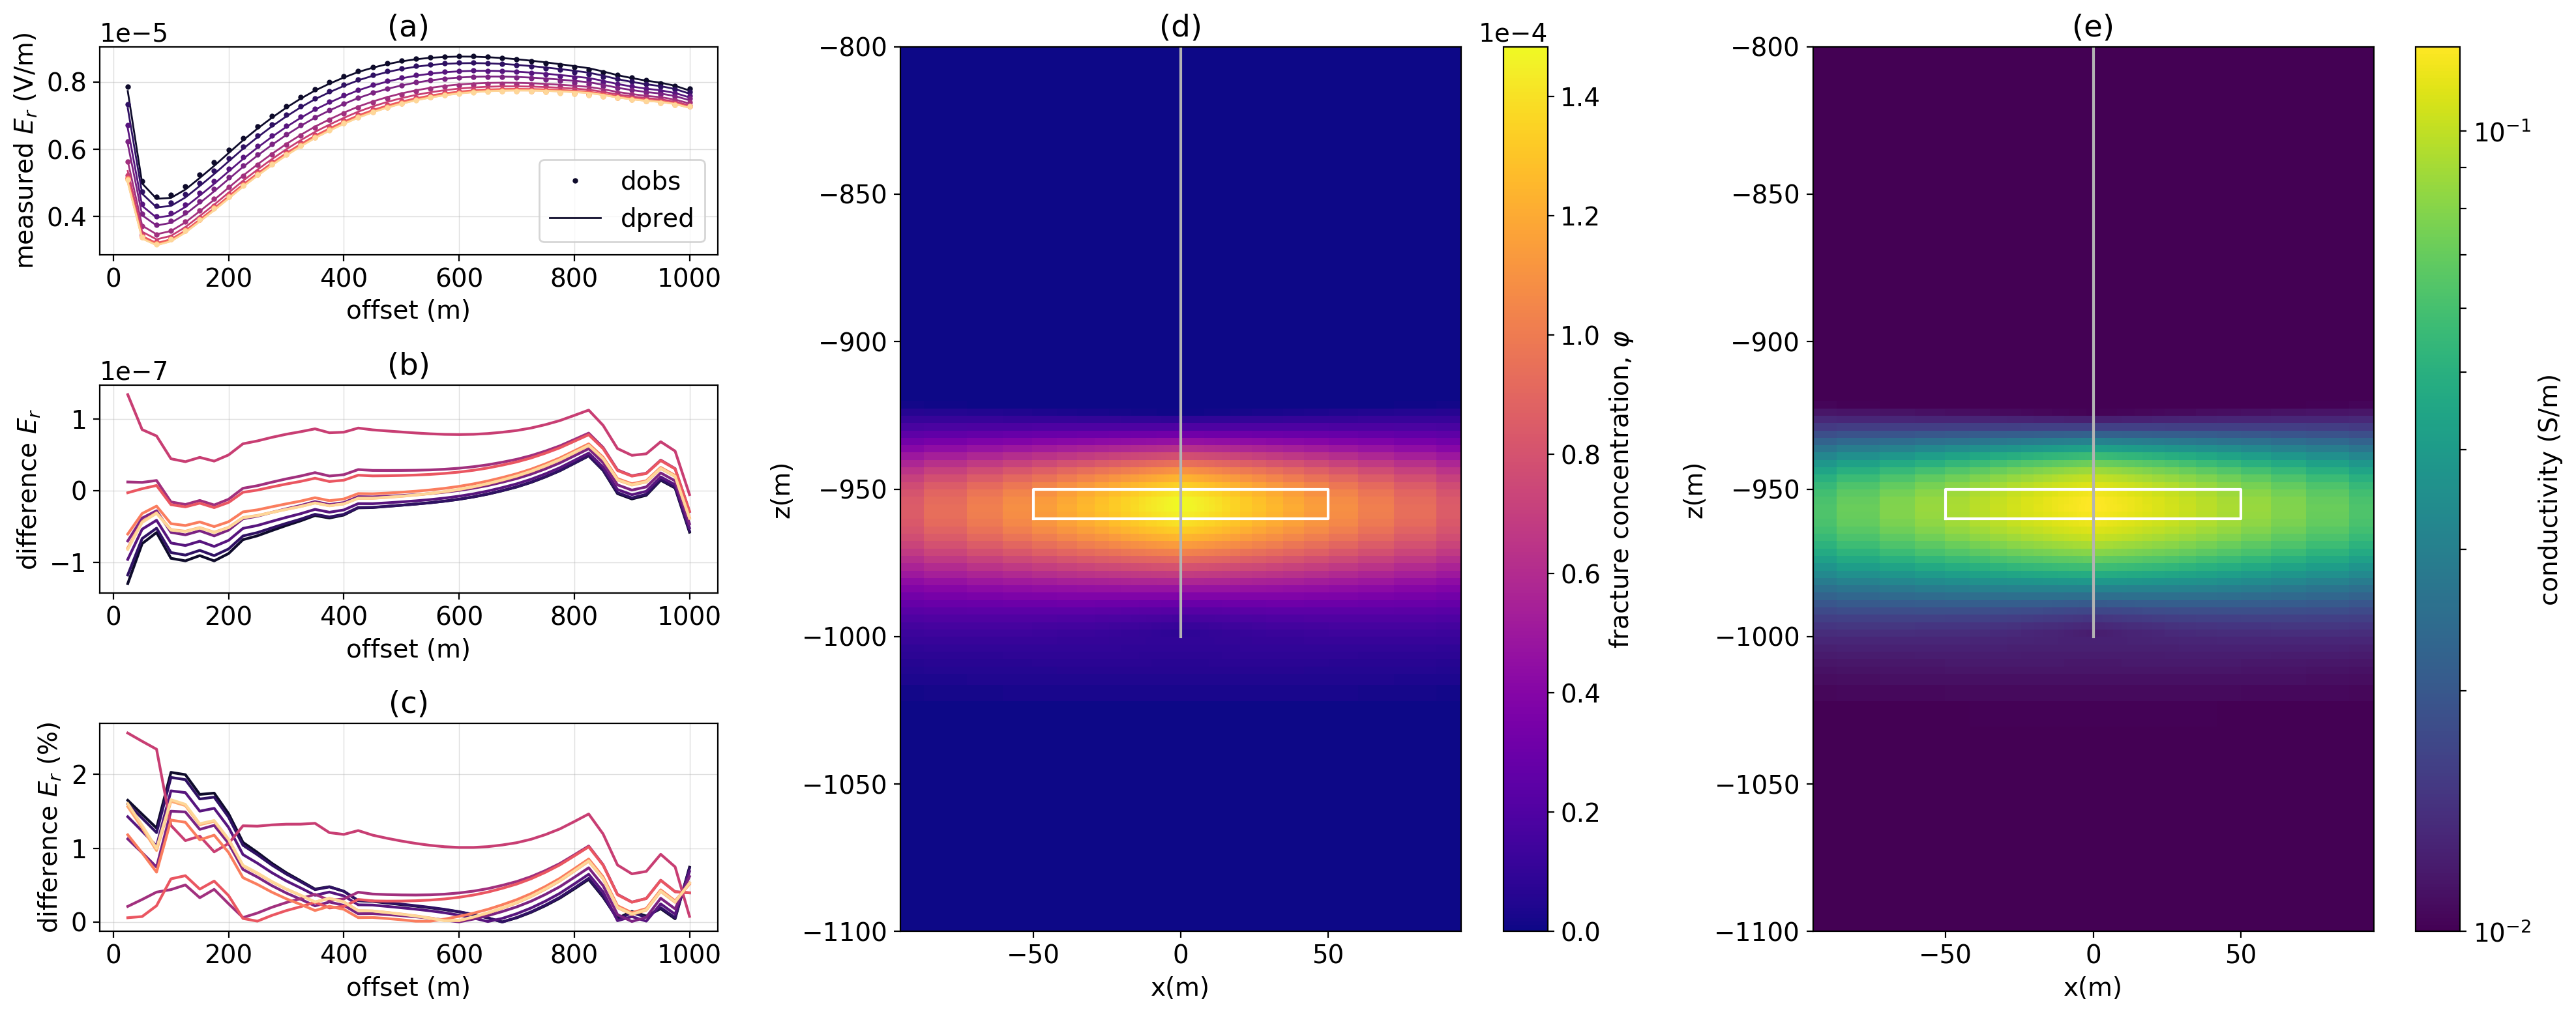

In [92]:
fig, ax, out = plot_inversion_phi(invProb_scemt.dpred,  mapping_scemt, mapping_scemt_phi, mrec_scemt, clim=np.r_[
        np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt).min()]), 
        (scemt_mapping * mrec_scemt).max()
    ])
fig.savefig('../figures/dc_smooth_inversion_phi_{:1.0e}'.format(CHIFACT), dpi=200)

In [93]:
print((mapping_scemt * mrec_scemt)[~ind_inactive].max())

0.12739920629111576


In [94]:
np.exp(mrec.max())

0.18149495541585223

## Add volume term

In [95]:
class Volume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    def __init__(self, mesh, **kwargs):
        super(Volume, self).__init__(mesh, **kwargs)

    def fields(self, m):
        self.model = m
        return np.r_[np.inner(self.mesh.vol, self.phi)]

    def Jvec(self, m, v, f=None):
        self.model = m
        return np.atleast_1d(np.inner(self.mesh.vol, self.phi_deriv*v))
#         return discretize.utils.sdiag(self.mesh.vol) * (self.phi_deriv * v)

    def Jtvec(self, m, v, f=None):
        self.model = m
#         return self.phi_deriv.T * (discretize.utils.sdiag(self.mesh.vol) * v)
        return discretize.utils.mkvc(
            self.phi_deriv.T * discretize.utils.mkvc(np.inner(np.atleast_2d(self.mesh.vol).T, v))
        )

class VolumeSurvey(Survey.BaseSurvey):
    def dpred(self, m, f=None):
        self.prob.model=m
        return self.prob.fields(m)

In [96]:
mapping_volume = Maps.InjectActiveCells(mesh, ~ind_inactive, 0)

In [97]:
mapping_volume.nP

38816

In [98]:
prob_vol = Volume(mesh, phi_map=mapping_volume)
survey_vol = VolumeSurvey()
prob_vol.pair(survey_vol)

In [99]:
m0_scemt = (1e-10 * np.ones(mapping_volume.nP, dtype=float))

In [100]:
survey_vol.dpred(m0_scemt)

array([28.82728597])

In [101]:
prob_vol.Jtvec(m0_scemt, np.r_[1])

array([8.06064978e-01, 2.41819493e+00, 4.03032489e+00, ...,
       1.42101356e+07, 2.66889699e+07, 5.21244295e+07])

In [102]:
x0 = m0_scemt
def vol_deriv(x):
    return prob_vol.fields(x), lambda h: prob_vol.Jvec(m0_scemt, h)

In [103]:
w = np.r_[100.]
v = np.random.rand(len(x0))
wJv = np.inner(w, prob_vol.Jvec(x0, v))
vJTw = np.inner(v, prob_vol.Jtvec(x0, w))

In [104]:
prob_vol.Jtvec(x0, w).shape

(38816,)

In [105]:
print(wJv, vJTw)

13134793879547.164 13134793879547.18


In [106]:
from SimPEG import Tests

In [107]:
Tests.checkDerivative(vol_deriv, x0=x0, plotIt=False, num=3, eps=1e-5)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.494e+08     5.275e-06      nan
 1   1.00e-02    1.494e+07     1.684e-06      0.496
 2   1.00e-03    1.494e+06     8.731e-08      1.285
========================= PASS! =========================
Once upon a time, a happy little test passed.



True

In [108]:
survey_vol.dobs = np.r_[V_frac]
survey_vol.std = 0.01
survey_vol.eps = 0
survey_vol.srcList = []

In [109]:
dmis_vol = DataMisfit.l2_DataMisfit(survey_vol)

In [110]:
x0 = np.random.rand(mapping_scemt.nP)
def vol_deriv(x):
    return dmis_vol(x), lambda h: np.inner(dmis_vol.deriv(x0), h)
Tests.checkDerivative(vol_deriv, x0=x0, num=6, plotIt=False)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.472e+18     5.706e+15      nan
 1   1.00e-02    1.477e+17     5.706e+13      2.000
 2   1.00e-03    1.477e+16     5.706e+11      2.000
 3   1.00e-04    1.477e+15     5.706e+09      2.000
 4   1.00e-05    1.477e+14     5.695e+07      2.001
 5   1.00e-06    1.477e+13     5.458e+05      2.019
========================= PASS! =========================
Go Test Go!



True

In [111]:
Tests.checkDerivative(vol_deriv, x0=x0, num=6, plotIt=False)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.597e+18     1.740e+16      nan
 1   1.00e-02    2.582e+17     1.740e+14      2.000
 2   1.00e-03    2.580e+16     1.740e+12      2.000
 3   1.00e-04    2.580e+15     1.740e+10      2.000
 4   1.00e-05    2.580e+14     1.740e+08      2.000
 5   1.00e-06    2.580e+13     1.823e+06      1.980
========================= PASS! =========================
Happy little convergence test!



True

In [112]:
dmis_vol.deriv(x0, 0.001*np.ones_like(x0)).shape

(38816,)

In [113]:
reg_scemt_vol = Regularization.Tikhonov(
    regmesh, alpha_s=1e-3, alpha_x=1, indActive=~ind_inactive, mref=np.zeros(mapping_scemt.nP)
)
dmis_scemt_vol = DataMisfit.l2_DataMisfit(survey_scemt) + dmis_vol
opt_scemt_vol = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=30, remember='xc', lower=0., upper=1., stepOffBoundsFact=1e-4
)
invProb_scemt_vol = InvProblem.BaseInvProblem(dmis_scemt_vol, reg_scemt_vol, opt_scemt_vol)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt_vol = Inversion.BaseInversion(invProb_scemt_vol, directiveList=directives)

In [114]:
mrec_scemt_vol = inv_scemt_vol.run(m0_scemt)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the Problem3D_CC problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.02e+08  4.24e+03  1.17e-16  4.24e+03    1.90e+02      0              
   1  9.02e+08  4.08e+03  5.93e-15  4.08e+03    1.77e+02      0              
   2  9.02e+08  3.33e+03  1.57e-10  3.33e+03    1.18e+02      2   Skip BFGS  
   3  1.13e+08  2.99e+03  1.56e-10  2.99e+03    1.19e+02      0              
   4  1.13e+08  2.61e+03  1.56e-10  2.61e+03    1.22e+02      0   Skip BFGS  
   5  1.13e+08  1.68e+03  1.17e-09  1.68e+03    1.15e+02      1              
   6  1.41e+07  7.54e+02  3.43e-09  7.54e+02    7.77e+01      0   Skip BFGS  
   7  1.41e+07  5.61e+02  6.4

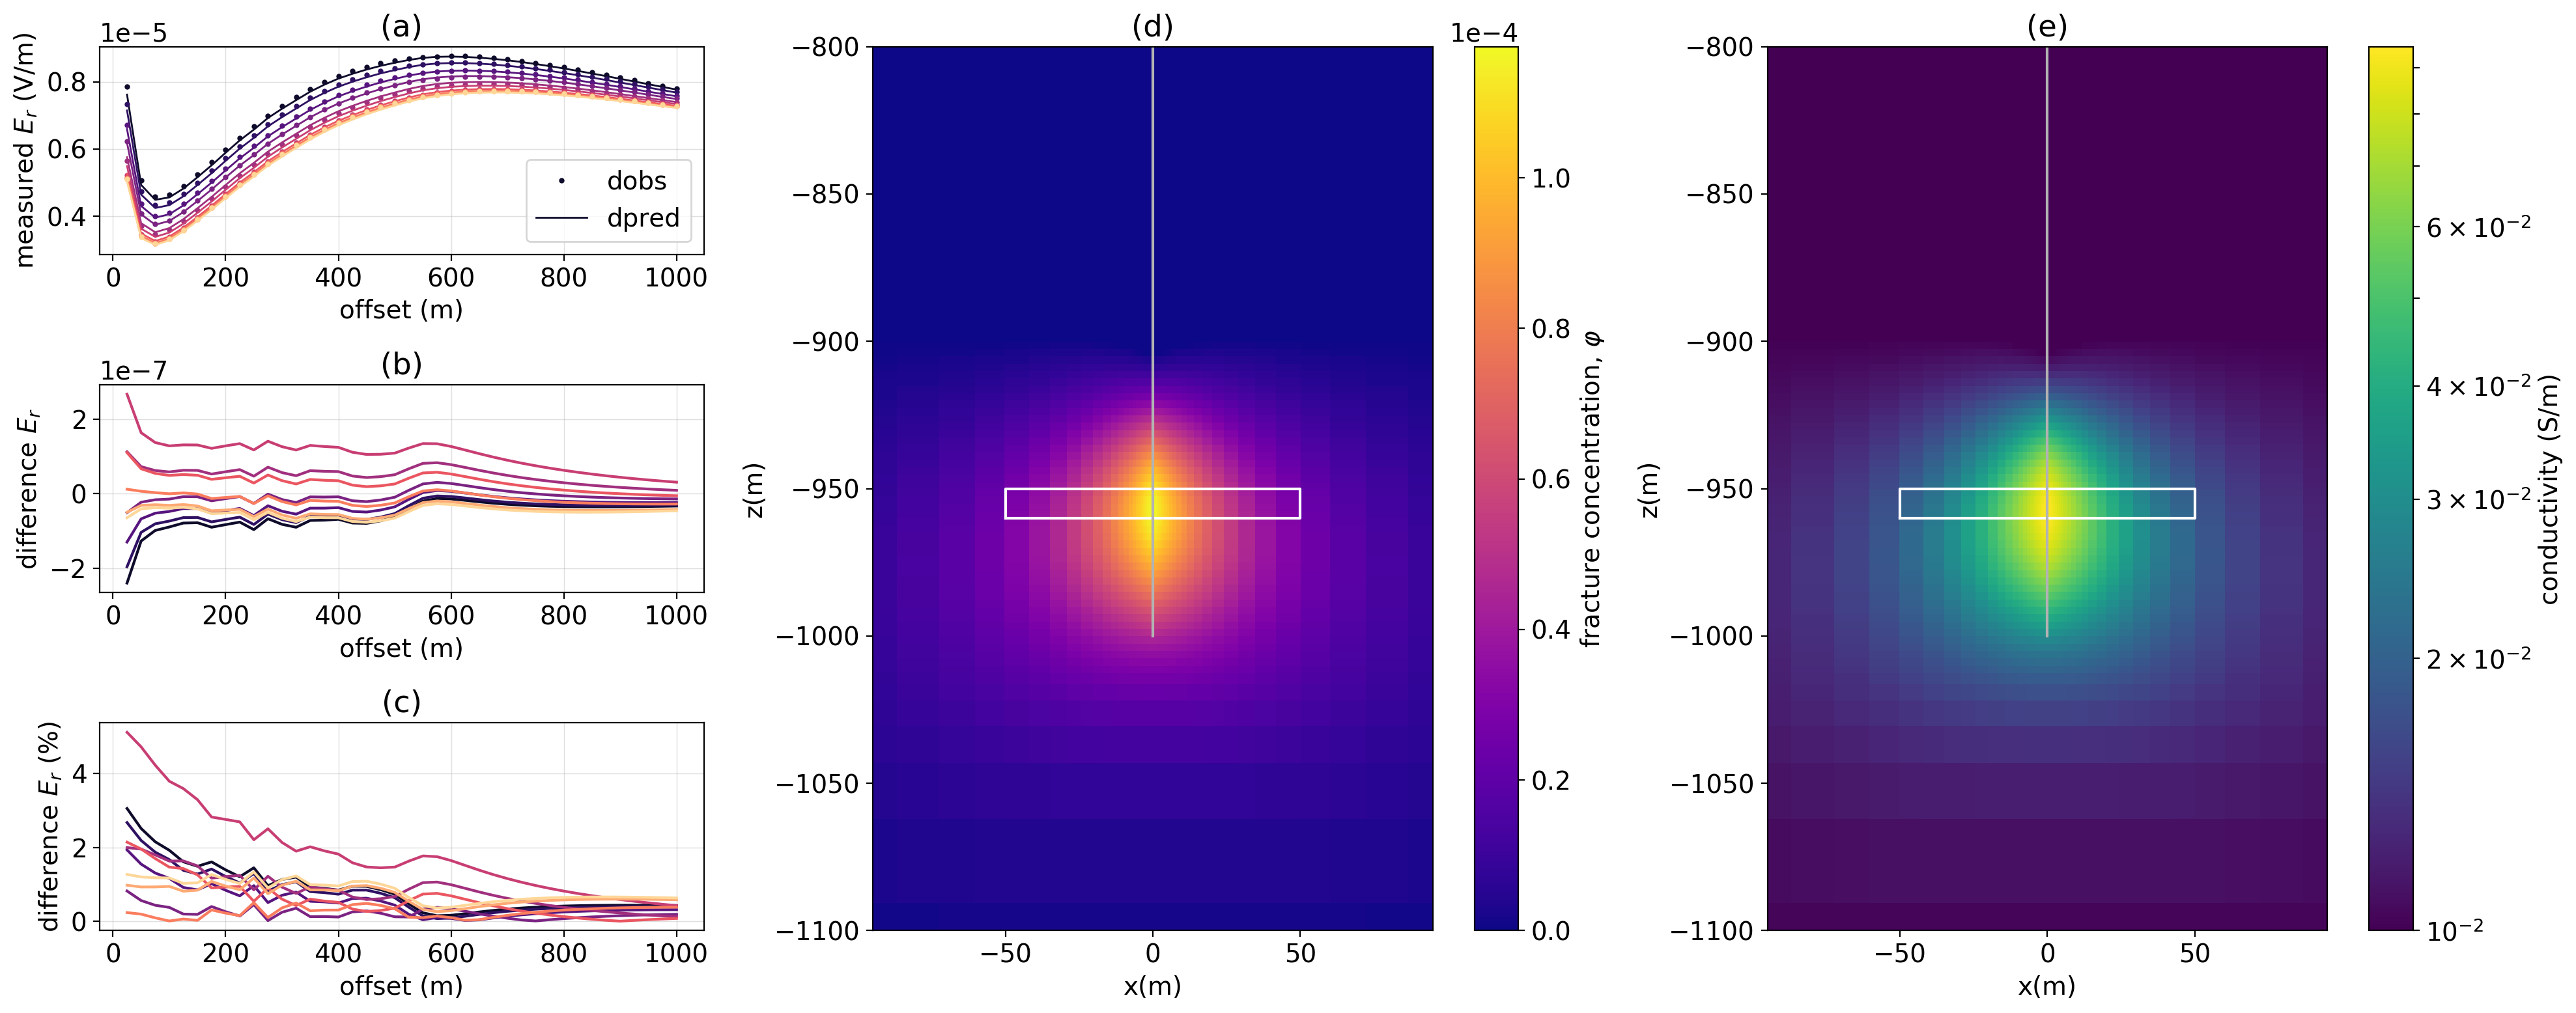

In [115]:
fig, ax, out = plot_inversion_phi(invProb_scemt_vol.dpred[0],  mapping_scemt, mapping_scemt_phi, mrec_scemt_vol, clim=np.r_[
        np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt_vol).min()]), 
        (scemt_mapping * mrec_scemt_vol).max()
    ])

# fig.savefig('../figures/dc_smooth_inversion_phi_{:1.0e}'.format(CHIFACT), dpi=200)
# fig, ax, out = plot_inversion(invProb_scemt_vol.dpred[0],  mapping_scemt, mrec_scemt_vol, clim=np.r_[
#     np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt_vol).min()]), 
#     (scemt_mapping * mrec_scemt_vol).max()
# ])
# # fig.savefig('../figures/dc_smooth_inversion_{:1.0e}'.format(CHIFACT), dpi=200)

### SCEMT + Parametric

In [128]:
# mapping_parametric
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive)
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=5e-2, p=4)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
# indActiveX0[2] = False
# InjectX0 = Maps.InjectActiveCells(
#     discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
#     valInactive=0.
# )

indActiveX0Z0 = np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0Z0[[2, 4]] = [False]*2
InjectX0Z0 = InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0Z0,
    valInactive=np.r_[0., np.mean(model.target_z)]
)

# mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0Z0

SCEMT2 = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)


scemt_parametric_map = InjectInactiveCells * SCEMT2 * ParametricBlock * InjectX0
scemt_parametric_map2phi = Maps.InjectActiveCells(mesh, ~ind_inactive, 0) * ParametricBlock * InjectX0

# scemt_parametric_map = InjectInactiveCells * SCEMT2 * ParametricBlock * InjectX0Z0
# scemt_parametric_map2phi = Maps.InjectActiveCells(mesh, ~ind_inactive, 0) * ParametricBlock * InjectX0Z0


In [129]:
prob_scemt, survey_scemt = get_prob_survey(scemt_parametric_map)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [130]:
experiment = 3
if experiment == 1:
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 10., model.target_z.mean(), 10.]
    name = "correctz0_dz"
elif experiment == 2:
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 10., model.target_z.mean(), 5.]
    name = "correctz0"
elif experiment == 3:
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 150., model.target_z.mean(), 5.]
    name = "correctz0_large_r"
# m0_scemt_parametric = np.hstack([np.r_[1e-10, 1e-4], m0_parametric[2:]])

In [131]:
## reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([scemt_parametric_map.nP]))

dmis_scemt = DataMisfit.l2_DataMisfit(survey_scemt)
opt_scemt = Optimization.ProjectedGNCG(
    maxIterCG=15, maxIter=30, remember='xc', 
    lower=np.hstack([2*[0.], 3*[-np.inf]]), upper=np.hstack([2*[1.], 3*[np.inf]]), stepOffBoundsFact=1e-10
)
invProb_scemt = InvProblem.BaseInvProblem(dmis_scemt, reg_parametric, opt_scemt, beta=0)
directives = [
#     Directives.BetaEstimate_ByEig(beta0_ratio=10),
#     Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory="scemt_parametric_{}".format(name)),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt = Inversion.BaseInversion(invProb_scemt, directiveList=directives)

In [132]:
m0_scemt_parametric

array([ 1.00e-10,  1.00e-04,  1.50e+02, -9.55e+02,  5.00e+00])

ValueError: Dimension mismatch in ComboMap[ComboMap[InjectActiveCells(42432,38816) * ParametricBlock(38816,6)](42432,6) * InjectActiveCells(6,4)](42432,4) and np.ndarray(5,).

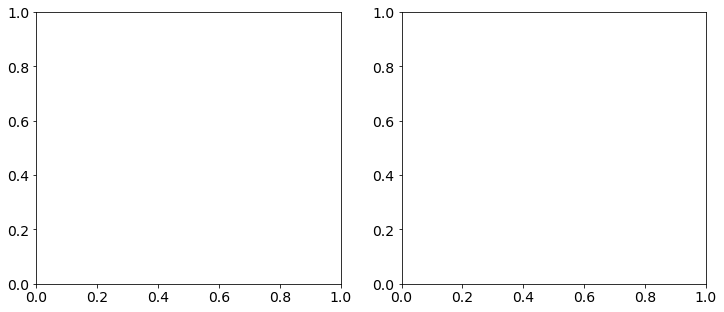

In [133]:
plot_models(m0_scemt_parametric, scemt_parametric_map2phi, phi=True)

In [ ]:
# scemt_parametric_map2.test(m0_scemt_parametric, dx=np.r_[1e-6, 0, 0, 0, 0])

In [ ]:
mrec_scemt_parametric = inv_scemt.run(m0_scemt_parametric)

In [ ]:
mrec_scemt_parametric

In [ ]:
plot_models(mrec_scemt_parametric, scemt_parametric_map, clim=np.r_[sigma_back, 5])

In [ ]:
(scemt_parametric_map * mrec_scemt_parametric)[~ind_inactive].max()

In [ ]:
m

In [ ]:
name = "scemt_parametric_correctz0"


In [ ]:
m = np.load('scemt_parametric_correctz0/'+ '012-InversionModel-2018-08-20-10-43.npy')
# m = np.load('scemt_parametric_correctz0_dz/'+ '011-InversionModel-2018-08-20-10-24.npy')

In [ ]:
fig, ax, out = plot_inversion_phi(
    invProb_scemt.dpred,  scemt_parametric_map, scemt_parametric_map2phi, 
    mrec_scemt_parametric, 
#     m,
    clim=np.r_[
        sigma_back, #np.min(np.r_[sigma_back, (scemt_parametric_map * mrec_scemt_parametric).min()]), 
        (scemt_parametric_map * mrec_scemt_parametric)[~ind_inactive].max()
    ]
)
block = block_plotting_coordinates(
    0, m0_scemt_parametric[2], m0_scemt_parametric[3] if len (m0_scemt_parametric) == 5 else InjectX0Z0.valInactive[4], 
    m0_scemt_parametric[4] if len(m0_scemt_parametric) == 5  else m0_scemt_parametric[3]
) 
for a in [ax[3], ax[4]]:
    a.plot(block[0], block[1], color="k", ls="--")
    
fig.savefig('../figures/dc_parametric_inversion_phi_{}'.format(name), dpi=200)



In [ ]:
name

In [414]:
mrec_scemt_parametric

array([ 0.00000000e+00,  9.80198373e-04,  1.51170914e+02, -9.52943074e+02,
        6.69246984e+00])

In [449]:
def plot_parametric(it=0):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    m = parametric_models[it]
    clim_rec = [np.min(np.r_[sigma_back, np.exp(m[:2].min())]), np.exp(m[:2].max())]

    out_rec = phys_props_dict[key].plot_prop(
        mapping_parametric * m, 
        pcolorOpts={'norm':LogNorm()}, clim=clim_rec, ax=ax
    )
    block_true = block_plotting_coordinates(
        0, model.target_radius[1]*2, model.target_z.mean(), model.target_z[1] - model.target_z[0]
    )
    block = block_plotting_coordinates(
        0, m0_parametric[2], m0_parametric[3] if len (m0_parametric) == 5 else InjectX0Z0.valInactive[4], 
        m0_parametric[4] if len(m0_parametric) == 5  else m0_parametric[3]
    )
    ax.plot(block_true[0], block_true[1], color="w", ls="-")
    ax.plot(block[0], block[1], color="w", ls="--")
    ax.set_xlim(80*np.r_[-1, 1])
    ax.set_ylim([-1100, -800])
    
    plt.show()

In [761]:
# print volume
prob_vol = Volume(mesh, phi_map=scemt_parametric_map2phi)
survey_vol = VolumeSurvey()
prob_vol.pair(survey_vol)

In [451]:
mrec_scemt_parametric_vol

NameError: name 'mrec_scemt_parametric_vol' is not defined

In [455]:
mrec_scemt_parametric[1] * np.pi*(mrec_scemt_parametric[2]**2 - 1e-2**2) * mrec_scemt_parametric[4]

470.962955267973

In [471]:
m[1] * np.pi*(m[2]**2 - 1e-2**2) * m[4]

226.19845696031027

In [419]:
V_frac

235.6194490192345

In [472]:
def load_models(directory): 
    return [
        np.load(directory + '/' + f) for f in
        sorted(os.listdir(directory)) if f.endswith('.npy')
    ]

In [490]:
log_parametric = [
    np.vstack(load_models(m)) for m in [
        "parametric_voxel2","parametric_voxel2_dz10", "parametric_voxel2_large_r"
    ]
]
phi_parametric = [
    np.vstack(load_models(m)) for m in [
        "scemt_parametric_correctz0", "scemt_parametric_correctz0_dz", "scemt_parametric_correctz0_large_r"
    ]
]

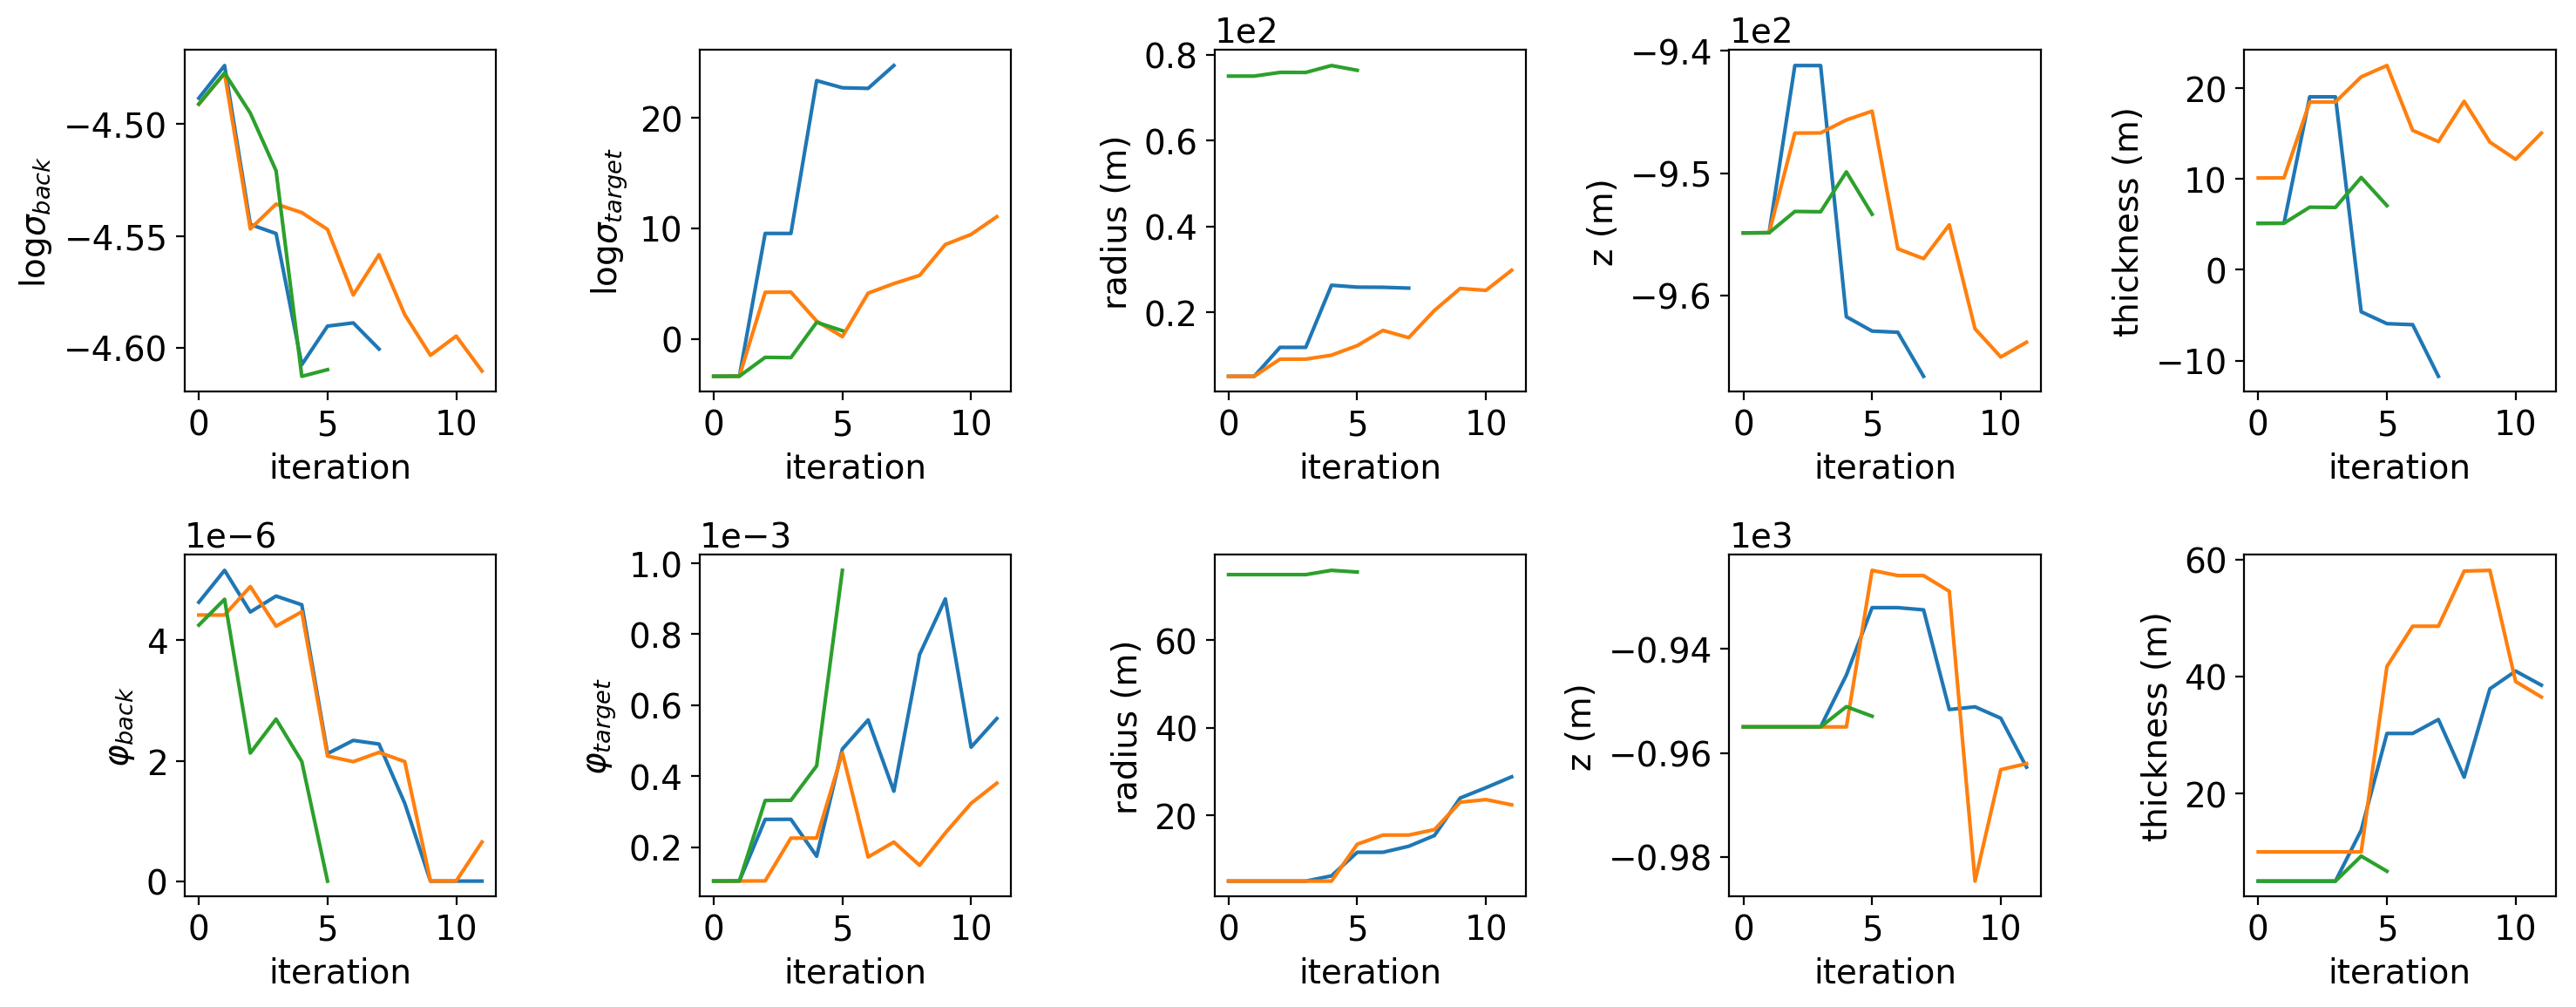

In [505]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6), dpi=200)

for k in range(3):
    for i, m in enumerate([log_parametric[k], phi_parametric[k]]):
        for j in range(5):
            ax[i, j].plot(m[:, j] if j!=2 else m[:, j]/2.)
            ax[i, j].ticklabel_format(style='sci', axis='y', scilimits=(0,2))
            
            ax[i, j].set_xlabel('iteration')

ax[0, 0].set_ylabel("log$\sigma_{back}$")
ax[0, 1].set_ylabel("log$\sigma_{target}$")

ax[1, 0].set_ylabel("$\\varphi_{back}$")
ax[1, 1].set_ylabel("$\\varphi_{target}$")

[ax[i, 2].set_ylabel("radius (m)") for i in range(2)]
[ax[i, 3].set_ylabel("z (m)") for i in range(2)]
[ax[i, 4].set_ylabel("thickness (m)") for i in range(2)]


plt.tight_layout()

## Include the volume term

In [75]:
model.casing_d

0.05

In [76]:
mesh.hx.min()*4

0.05

In [86]:
class ParametricVolume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    radius, radius_map, radius_deriv = Props.Invertible(
        "radius of the target"
    )
    
    dz, dz_map, dz_deriv = Props.Invertible(
        "width in the z-dimension of the target"
    )
    
    def __init__(self, mesh, **kwargs):
        super(ParametricVolume, self).__init__(mesh, **kwargs)

    def fields(self, m):
        self.model = m
        return np.r_[np.pi*(self.radius**2 - model.casing_b**2) * self.dz * self.phi]

    def Jvec(self, m, v, f=None):
        self.model = m
        return (
            np.pi * (2*self.radius) * self.dz * self.phi * (self.radius_deriv * v) +
            np.pi*(self.radius**2 - model.casing_b**2) * self.phi * (self.dz_deriv * v) +
            np.pi*(self.radius**2 - model.casing_b**2) * self.dz * (self.phi_deriv * v)
        )
            
    def Jtvec(self, m, v, f=None):
        self.model = m
        return (
            np.pi * (2*self.radius) * self.dz * self.phi * (self.radius_deriv.T * v) +
            np.pi*(self.radius**2 - model.casing_b**2) * self.phi * (self.dz_deriv.T * v) +
            np.pi*(self.radius**2 - model.casing_b**2) * self.dz * (self.phi_deriv.T * v)
        )


In [87]:
# wires = Maps.Wires(
#     ('phi_background', 1), ('phi_frac', 1), ('radius', 1), ('depth', 1), ('dz', 1)
# )

wires = Maps.Wires(
    ('phi_background', 1), ('phi_frac', 1), ('radius', 1), ('dz', 1)
)
prob_vol = ParametricVolume(
    discretize.TensorMesh([3]),
    phi_map=wires.phi_frac, radius_map=wires.radius, dz_map=wires.dz
)

In [88]:
survey_vol = VolumeSurvey()
survey_vol.dobs = np.r_[V_frac]
survey_vol.std = 0.05
survey_vol.eps = 0
survey_vol.srcList = []

prob_vol.pair(survey_vol)

In [89]:
dmis_vol = DataMisfit.l2_DataMisfit(survey_vol)

In [90]:
dmis_vol.nP

'*'

In [91]:
def vol_deriv(x):
    return dmis_vol(x), lambda h: np.inner(dmis_vol.deriv(x0), h)


In [92]:
from SimPEG import Tests

In [93]:
m0_scemt_parametric

NameError: name 'm0_scemt_parametric' is not defined

In [94]:
x0 = m0_scemt_parametric
Tests.checkDerivative(vol_deriv, x0=x0, num=6, plotIt=False)

NameError: name 'm0_scemt_parametric' is not defined

In [771]:
w = np.r_[100.]
v = x0
wJv = np.dot(w, prob_vol.Jvec(x0, v))
vJTw = np.dot(v.T, prob_vol.Jtvec(x0, w))
print(wJv, vJTw)

14137.166155755907 14137.166155755905


In [772]:
experiment = 3
if experiment == 1:
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 10., model.target_z.mean(), 10.]
    name = "correctz0_dz"
elif experiment == 2:
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 10., model.target_z.mean(), 5.]
    name = "correctz0"
elif experiment == 3:
#     m0_scemt_parametric = np.r_[1e-10, 1e-4, 150., model.target_z.mean(), 5.]        
    m0_scemt_parametric = np.r_[1e-10, 1e-4, 150.,  5.]

    name = "correctz0_large_r"

directory = "scemt_parametric_{}".format(name)
m0_scemt_parametric_vol = [
    np.load(directory + '/' + f) for f in
    sorted(os.listdir(directory)) if f.endswith('.npy')
][-1]

In [773]:
m0_scemt_parametric_vol

array([ 0.00000000e+00,  9.80198373e-04,  1.51170914e+02, -9.52943074e+02,
        6.69246984e+00])

In [782]:
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([scemt_parametric_map.nP]))

dmis_scemt = DataMisfit.l2_DataMisfit(survey_scemt) + dmis_vol
opt_scemt = Optimization.ProjectedGNCG(
    maxIterCG=15, maxIter=30, remember='xc', 
    lower=np.hstack([2*[0.], 2*[-np.inf]]), upper=np.hstack([2*[1.], 2*[np.inf]]), stepOffBoundsFact=1e-10
)
invProb_scemt = InvProblem.BaseInvProblem(dmis_scemt, reg_parametric, opt_scemt, beta=0)
directives = [
#     Directives.BetaEstimate_ByEig(beta0_ratio=10),
#     Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory="scemt_parametric_vol_{}_{}_fixed_z0".format(name, survey_vol.std)),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt_vol = Inversion.BaseInversion(invProb_scemt, directiveList=directives)

In [783]:
m0_scemt_parametric

array([1.0e-10, 1.0e-04, 1.5e+02, 5.0e+00])

In [784]:
mrec_parametric_scemt_vol = inv_scemt_vol.run(m0_scemt_parametric)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the Problem3D_CC problem***
SimPEG.SaveModelEveryIteration will save your models as: 'scemt_parametric_vol_correctz0_large_r_0.05_fixed_z0/###-InversionModel-2018-08-21-13-42.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.79e+03  8.70e+04  2.79e+03    3.04e+01      0              
   1  0.00e+00  3.49e+02  8.70e+04  3.49e+02    1.29e+01      0              
   2  0.00e+00  3.32e+02  8.70e+04  3.32e+02    1.16e+01      0   Skip BFGS  
   3  0.00e+00  2.05e+02  8.70e+04  2.05e+02    1.99e+01      0   Skip BFGS  
   4  0.00e+00  6.67e+01  8.70e+04  6.67e+01    3.58e+01 

In [751]:
mrec_parametric_scemt_vol

array([ 4.73263876e-07,  1.01642984e-03,  1.49528697e+02, -9.57520623e+02,
        3.10479525e+00])

In [750]:
print_parametric(mrec_parametric_scemt_vol)

sigma back   : 1.00e+00 S/m
sigma target : 1.00e+00 S/m
target radius: 74.76 m
target top   : -955.97 m
target_bottom: -959.07 m



In [740]:
prob_vol.fields(mrec_parametric_scemt_vol)

array([221.67120907])

In [741]:
prob_vol.survey.dobs

array([235.61944902])

In [742]:
dmis_vol(mrec_parametric_scemt_vol)

0.7008846412269905

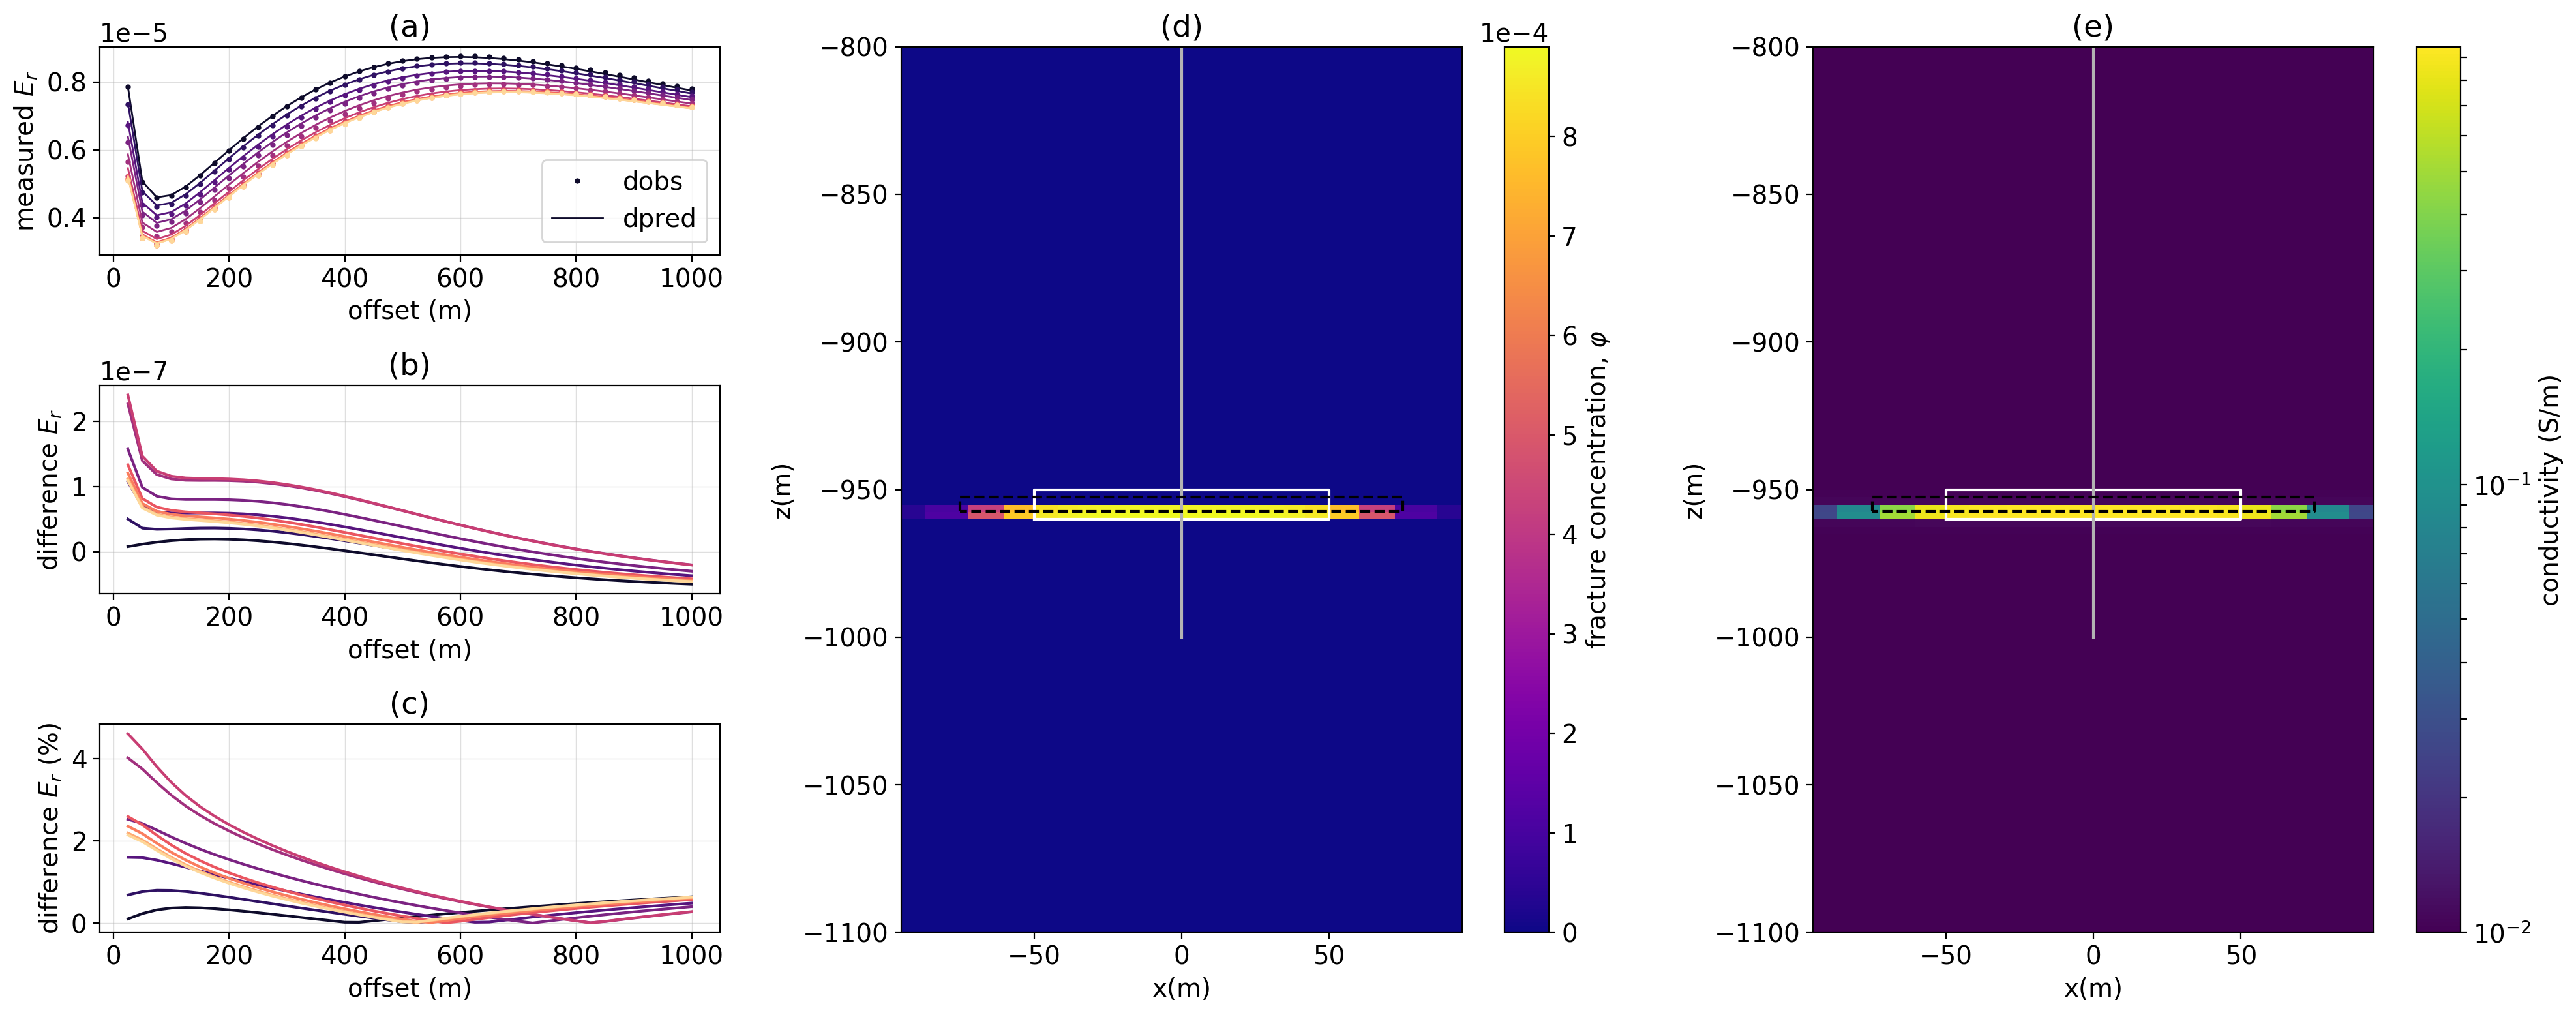

In [748]:
fig, ax, out = plot_inversion_phi(
    invProb_scemt.dpred[0],  scemt_parametric_map, scemt_parametric_map2phi, 
    mrec_parametric_scemt_vol, 
#     clim=np.r_[
#         np.min(np.r_[sigma_back, (scemt_mapping * mrec_parametric_scemt_vol).min()]), 
#         (scemt_mapping * mrec_parametric_scemt_vol).max()
#     ]
    clim=np.r_[
        sigma_back, #np.min(np.r_[sigma_back, (scemt_parametric_map * mrec_scemt_parametric).min()]), 
        (scemt_parametric_map * mrec_parametric_scemt_vol)[~ind_inactive].max()
    ]
)
block = block_plotting_coordinates(
    0, m0_scemt_parametric[2], m0_scemt_parametric[3] if len (m0_scemt_parametric) == 5 else InjectX0Z0.valInactive[4], 
    m0_scemt_parametric[4] if len(m0_scemt_parametric) == 5  else m0_scemt_parametric[3]
) 
for a in [ax[3], ax[4]]:
    a.plot(block[0], block[1], color="k", ls="--")
    
fig.savefig('../figures/dc_parametric_inversion_phi_vol_{}_fixed_z0'.format(name), dpi=200)



# Sensitivities

In [723]:
m_true_scemt = np.r_[0., phi_frac, model.target_radius[1], model.target_z.mean(), model.target_z[1] - model.target_z[0]]
Jscemt_true = prob_scemt.getJ(m_true_scemt)

In [734]:
m_true_logs = np.r_[np.log(sigma_back), np.log(sigma_frac), model.target_radius[1], model.target_z.mean(), model.target_z[1] - model.target_z[0]]
Jlogs_true = prob_parametric.getJ(m_true_logs)

In [726]:
sens_scemt = np.sqrt((Jscemt_true**2).sum(0))
sens_scemt

array([4.02461533e+00, 9.21306855e-04, 1.47736434e-07, 1.56661911e-07,
       2.45653915e-07])

In [727]:
sens_parametric = np.sqrt((Jlogs_true**2).sum(0))
sens_parametric

array([1.75670800e-04, 1.22482119e-06, 1.74197550e-07, 9.82453418e-08,
       2.08925237e-07])

In [728]:
(np.exp(np.log(sigma_back) + sens_parametric[0]) - np.exp(np.log(sigma_back) - sens_parametric[0]))/2

1.756708012943739e-06

In [718]:
(np.exp(np.log(sigma_frac) + sens_parametric[1]) - np.exp(np.log(sigma_frac) - sens_parametric[1]))/2

4.049812587059165e-06

In [721]:
np.dot(Jscemt_true.T, survey_inv.dobs)

array([-5.48416679e-04, -1.12461296e-07, -1.79178388e-11,  1.93244650e-11,
       -3.02101004e-11])

In [722]:
np.dot(Jlogs_true.T, survey_inv.dobs)

array([-2.37889362e-08, -1.49014560e-10, -2.10711496e-11,  1.04053920e-11,
       -2.54761531e-11])

In [732]:
0.1* m_true_scemt * sens_scemt

array([ 0.00000000e+00,  2.76392057e-07,  7.38682171e-07, -1.49612125e-05,
        2.45653915e-07])

In [736]:
0.1* m_true_logs * sens_parametric

array([-8.08993933e-05,  1.46473395e-07,  8.70987751e-07, -9.38243014e-06,
        2.08925237e-07])

## L2 inversion on uniformly spaced mesh

In [50]:
casing_region = regmesh.hx[regmesh.hx < cylMeshGen.csz].sum()
ncells = int(np.ceil(casing_region/cylMeshGen.csz))
casing_region_h = np.ones(ncells) * casing_region/ncells

regmesh2 = discretize.TensorMesh(
    [
        np.hstack([casing_region_h, regmesh.hx[regmesh.hx >= cylMeshGen.csz]]), 
        regmesh.hy[regmesh.vectorCCy <= 0]
    ],
    x0=np.r_[0., -regmesh.hy[regmesh.vectorCCy <= 0].sum()]
)


In [ ]:
mesh2mesh = Maps.Mesh2Mesh([regmesh, regmesh2], indActive = np.where(~ind_inactive)[0])
mapping2 = ExpMap * InjectInactiveCells * mesh2mesh

In [ ]:
prob_inv2, survey_inv2 = get_prob_survey(mapping2)

In [ ]:
reg2 = Regularization.Tikhonov(regmesh2, alpha_s=1e-3)
dmis2 = DataMisfit.l2_DataMisfit(survey_inv2)
opt2 = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=5, remember='xc')
invProb2 = InvProblem.BaseInvProblem(dmis2, reg2, opt2)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv2 = Inversion.BaseInversion(invProb2, directiveList=directives)

In [ ]:
m02 = np.ones(regmesh2.nC) * np.log(sigma_back)

In [ ]:
%%time
mrec2 = inv2.run(m02)

In [ ]:
plot_models(mrec2, mapping2, xlim=80*np.r_[-1, 1])

In [ ]:
dpred2 = invProb2.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred2)

## sparse inversion

In [817]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
# reg = Regularization.Tikhonov(regmesh, alpha_s=1e-1, indActive=~ind_inactive)
reg_sparse = Regularization.Sparse(
    regmesh, indActive=~ind_inactive,
    gradientType='components', 
    mapping=Maps.IdentityMap(nP=(~ind_inactive).sum()),
    alpha_s=1e-3, alpha_x=100
)
reg_sparse.cell_weights = regmesh.vol[~ind_inactive]
#     gradientType = 'components'
reg_sparse.norms = np.c_[0., 2., 2., 2.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1,
    betaSearch=True, fix_Jmatrix=False, 
    chifact_start=CHIFACT, beta_ratio_l2=10, 
    coolingFactor=8, coolingRate=3
)
# update_sensitivity = Directives.UpdateSensitivityWeights(threshold=1e-3)
dmis_sparse = DataMisfit.l2_DataMisfit(survey_inv)
opt_sparse = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
invProb_sparse = InvProblem.BaseInvProblem(dmis_sparse, reg_sparse, opt_sparse)
directives_sparse = [
    IRLS,
#     update_sensitivity, 
#     Directives.UpdatePreconditioner(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_sparse = Inversion.BaseInversion(invProb_sparse, directiveList=directives_sparse)

/Users/lindseyjh/git/python_symlinks/SimPEG/Directives.py:886: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


In [818]:
%%time
mrec_sparse = inv_sparse.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.28e+03  0.00e+00  1.28e+03    5.97e+02      0              
   1  1.00e+00  7.42e+01  1.95e+01  9.37e+01    6.93e+01      0              
   2  1.00e+00  4.03e+01  3.41e+01  7.44e+01    4.33e+00      0   Skip BFGS  
   3  1.25e-01  4.12e+01  3.27e+01  4.53e+01    2.93e+01      0              
   4  1.25e-01  1.52e+01  1.09e+02  2.88e+01    1.13e+01      0              
   5  1.25e-01  1.43e+01  1.08e+02  2.79e+01    6.85e+00      0              
   6  1.56e-02  1.31e+01  1.16e+02  1.49e+01    1.07e+01      0   

/Users/lindseyjh/git/python_symlinks/SimPEG/Directives.py:763: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


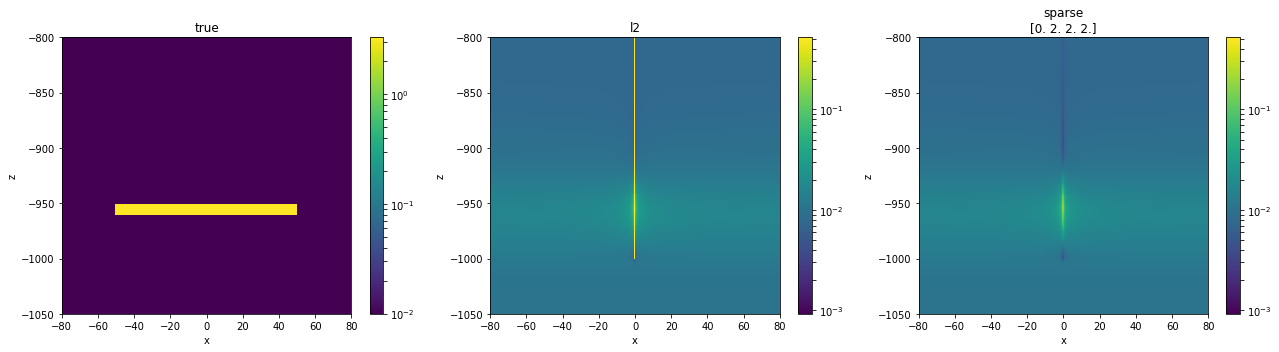

In [819]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -800]
clim = [np.min(np.r_[sigma_back, np.exp(mrec_sparse.min())]), np.exp(mrec_sparse.max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * invProb_sparse.l2model, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * mrec_sparse, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim
)

for a, title in zip(ax, ["true", "l2", "sparse\n{}".format(reg_sparse.norms[0, :])]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
dpred_sparse = invProb_sparse.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred_sparse)

In [136]:
a = np.load('scemt_parametric_correctz0_large_r/005-InversionModel-2018-08-20-11-12.npy')

In [137]:
a

array([ 1.98660649e-06,  4.29083526e-04,  1.51954017e+02, -9.51107533e+02,
        9.28413703e+00])

In [138]:
a = np.load('scemt_parametric_correctz0_dz/011-InversionModel-2018-08-20-10-24.npy')

In [139]:
a

array([ 6.49889427e-07,  3.80382945e-04,  4.48452011e+01, -9.62069722e+02,
        3.64983976e+01])